In [4]:
import os
import pandas as pd
import numpy as np
import librosa
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold

def extract_number(filename):
    match = re.match(r'(\d+)-MFCC\.csv', filename)
    return int(match.group(1)) if match else float('inf')

def calculate_rhythm_features(mfcc_data):
    """Calculate rhythm-related features from MFCC data."""
    # Calculate frame-to-frame differences
    frame_diff = np.diff(mfcc_data, axis=1)
    
    # Calculate energy in different frequency bands
    energy_bands = np.mean(np.square(mfcc_data), axis=1)
    
    # Calculate rhythmic regularity using autocorrelation of frame differences
    ac = np.correlate(frame_diff[0], frame_diff[0], mode='full')
    ac = ac[len(ac)//2:]  # Take only the positive lags
    rhythm_regularity = np.mean(ac[:20])
    
    # Calculate variance of frame differences as a measure of rhythmic activity
    rhythm_activity = np.var(frame_diff)
    
    return np.array([rhythm_regularity, rhythm_activity])

def calculate_spectral_features(mfcc_data):
    """Calculate spectral features from MFCC data."""
    # Spectral spread (variance across frequency bands)
    spectral_spread = np.var(mfcc_data, axis=0).mean()
    
    # Spectral flux (frame-to-frame spectral difference)
    spectral_flux = np.mean(np.diff(mfcc_data, axis=1)**2)
    
    # Spectral flatness
    spectral_flatness = np.exp(np.mean(np.log(np.abs(mfcc_data) + 1e-10))) / (np.mean(np.abs(mfcc_data)) + 1e-10)
    
    # Spectral entropy
    normalized_spectrum = np.abs(mfcc_data) / (np.sum(np.abs(mfcc_data)) + 1e-10)
    spectral_entropy = -np.sum(normalized_spectrum * np.log2(normalized_spectrum + 1e-10))
    
    return np.array([spectral_spread, spectral_flux, spectral_flatness, spectral_entropy])

def calculate_correlation_features(mfcc_data):
    """Calculate correlation-based features between MFCC coefficients."""
    # Correlation matrix between MFCC coefficients
    corr_matrix = np.corrcoef(mfcc_data)
    
    # Extract upper triangle of correlation matrix (excluding diagonal)
    upper_tri = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)]
    
    # Calculate statistics of correlations
    corr_mean = np.mean(upper_tri)
    corr_std = np.std(upper_tri)
    corr_max = np.max(np.abs(upper_tri))
    
    return np.array([corr_mean, corr_std, corr_max])

def process_mfcc_file(filepath):
    """Process a single MFCC file and extract enhanced features."""
    mfcc_data = pd.read_csv(filepath, header=None)
    
    if mfcc_data.shape[0] != 20:
        print(f"Warning: File {filepath} does not have 20 rows; skipping.")
        return None
    
    # Convert to numpy array for processing
    mfcc_array = mfcc_data.values
    
    # Basic statistical features
    mean_vals = np.mean(mfcc_array, axis=1)
    std_vals = np.std(mfcc_array, axis=1)
    median_vals = np.median(mfcc_array, axis=1)
    max_vals = np.max(mfcc_array, axis=1)
    min_vals = np.min(mfcc_array, axis=1)
    skew_vals = np.array([pd.Series(row).skew() for row in mfcc_array])
    kurtosis_vals = np.array([pd.Series(row).kurtosis() for row in mfcc_array])
    
    # Dynamic features
    delta_vals = librosa.feature.delta(mfcc_array)
    delta_delta_vals = librosa.feature.delta(mfcc_array, order=2)
    
    delta_mean_vals = np.mean(delta_vals, axis=1)
    delta_std_vals = np.std(delta_vals, axis=1)
    delta_delta_mean_vals = np.mean(delta_delta_vals, axis=1)
    delta_delta_std_vals = np.std(delta_delta_vals, axis=1)
    
    # Additional features
    rhythm_features = calculate_rhythm_features(mfcc_array)
    spectral_features = calculate_spectral_features(mfcc_array)
    correlation_features = calculate_correlation_features(mfcc_array)
    
    # Energy features
    energy = np.mean(np.square(mfcc_array), axis=1)
    energy_entropy = -np.sum(energy * np.log2(energy + 1e-10))
    
    # Combine all features
    return np.concatenate([
        mean_vals,                 # Basic statistical features
        std_vals,
        median_vals,
        max_vals,
        min_vals,
        skew_vals,
        kurtosis_vals,
        delta_mean_vals,          # Dynamic features
        delta_std_vals,
        delta_delta_mean_vals,
        delta_delta_std_vals,
        rhythm_features,          # Rhythm features
        spectral_features,        # Spectral features
        correlation_features,     # Correlation features
        energy,                   # Energy features
        [energy_entropy]          # Energy entropy
    ])

def calculate_vif(df):
    """Calculate VIF for each feature in the DataFrame."""
    vif_df = pd.DataFrame()
    vif_df["Feature"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

def reduce_features_vif(data, vif_threshold=10, max_iterations=10):
    """Reduce features using VIF threshold."""
    selector = VarianceThreshold(threshold=1e-4)
    data_reduced = data.loc[:, selector.fit(data).get_support()]
    
    iteration = 0
    while iteration < max_iterations:
        vif_data = calculate_vif(data_reduced)
        max_vif = vif_data["VIF"].max()
        
        if max_vif < vif_threshold:
            break
        
        feature_to_remove = vif_data.loc[vif_data["VIF"] == max_vif, "Feature"].values[0]
        data_reduced = data_reduced.drop(columns=[feature_to_remove])
        iteration += 1
    
    return data_reduced

def main():
    # Directory setup
    mfcc_folder = "/kaggle/input/mfcc-files/MFCC-files-v2-20241024"
    
    # Initialize lists
    train_features = []
    test_features = []
    train_file_numbers = []
    test_file_numbers = []
    
    # Create expanded column names
    columns = []
    for feature in ['mean', 'std', 'median', 'max', 'min', 'skew', 'kurtosis']:
        columns.extend([f"{feature}(c{i})" for i in range(20)])
    
    for feature in ['delta_mean', 'delta_std', 'delta_delta_mean', 'delta_delta_std']:
        columns.extend([f"{feature}(c{i})" for i in range(20)])
    
    columns.extend(['rhythm_regularity', 'rhythm_activity'])
    columns.extend(['spectral_spread', 'spectral_flux', 'spectral_flatness', 'spectral_entropy'])
    columns.extend(['correlation_mean', 'correlation_std', 'correlation_max'])
    columns.extend([f'energy_{i}' for i in range(20)])
    columns.append('energy_entropy')
    
    # Process files
    for filename in sorted(os.listdir(mfcc_folder), key=extract_number):
        if filename.endswith(".csv"):
            file_number = extract_number(filename)
            filepath = os.path.join(mfcc_folder, filename)
            
            features = process_mfcc_file(filepath)
            if features is None:
                continue
                
            if file_number <= 116:
                train_features.append(features)
                train_file_numbers.append(file_number)
                print(f"Processed training file {file_number}")
            elif 117 <= file_number <= 122:
                test_features.append(features)
                test_file_numbers.append(file_number)
                print(f"Processed test file {file_number}")
    
    # Create DataFrames
    train_df = pd.DataFrame(train_features, columns=columns)
    test_df = pd.DataFrame(test_features, columns=columns)
    
    # Reduce features
    print("\nReducing features...")
    train_reduced = reduce_features_vif(train_df)
    test_reduced = test_df[train_reduced.columns]
    
    # Apply PCA
    print("\nApplying PCA...")
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_reduced)
    test_scaled = scaler.transform(test_reduced)
    
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(train_scaled)
    test_pca = pca.transform(test_scaled)
    
    # Clustering
    print("\nPerforming clustering...")
    kmeans = KMeans(n_clusters=6, random_state=42)
    train_clusters = kmeans.fit_predict(train_pca)
    test_clusters = kmeans.predict(test_pca)
    
    # Visualization
    train_pca_df = pd.DataFrame(train_pca, columns=['PC1', 'PC2'])
    train_pca_df['Cluster'] = train_clusters
    train_pca_df['FileNumber'] = train_file_numbers
    
    test_pca_df = pd.DataFrame(test_pca, columns=['PC1', 'PC2'])
    test_pca_df['Cluster'] = test_clusters
    test_pca_df['FileNumber'] = test_file_numbers
    
    plt.figure(figsize=(12, 8))
    
    # Plot training data
    sns.scatterplot(data=train_pca_df, x='PC1', y='PC2', hue='Cluster', 
                    palette='viridis', alpha=0.5, s=60, legend=False)
    
    # Plot test data
    sns.scatterplot(data=test_pca_df, x='PC1', y='PC2', hue='Cluster', 
                    palette='viridis', marker='s', s=100, legend=False)
    
    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    train_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='Training')
    test_legend = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='k', markersize=8, label='Test')
    plt.legend([train_legend, test_legend] + handles, ["Training", "Test"] + labels, title="Cluster")
    
    # Annotate points
    for i, txt in enumerate(train_file_numbers):
        plt.text(train_pca_df['PC1'][i], train_pca_df['PC2'][i], txt, fontsize=8, ha='right')
    
    for i, txt in enumerate(test_file_numbers):
        plt.text(test_pca_df['PC1'][i], test_pca_df['PC2'][i], txt, fontsize=8, ha='right')
    
    plt.title("Enhanced Clustering with Advanced MFCC Features")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()
    
    # Save results
    train_pca_df[['FileNumber', 'Cluster']].to_csv("train_cluster_mapping.csv", index=False)
    test_pca_df[['FileNumber', 'Cluster']].to_csv("test_cluster_mapping.csv", index=False)
    
    # Print summary statistics
    print("\nTraining Data Summary:")
    print(f"Number of training files: {len(train_file_numbers)}")
    print("Cluster distribution in training data:")
    print(pd.Series(train_clusters).value_counts().sort_index())
    
    print("\nTest Data Summary:")
    print(f"Number of test files: {len(test_file_numbers)}")
    print("Cluster assignments for test files:")
    for file_num, cluster in zip(test_file_numbers, test_clusters):
        print(f"File {file_num}: Cluster {cluster}")
    
    print(f"\nNumber of features after reduction: {train_reduced.shape[1]}")
    print(f"\nVariance explained by principal components:")
    variance_ratio = pca.explained_variance_ratio_
    print(f"PC1: {variance_ratio[0]:.2%}")
    print(f"PC2: {variance_ratio[1]:.2%}")
    print(f"Total: {sum(variance_ratio):.2%}")

if __name__ == "__main__":
    main()

Processed training file 1
Processed training file 2
Processed training file 3
Processed training file 4
Processed training file 5


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def extract_number(filename):
    match = re.match(r'(\d+)-MFCC\.csv', filename)
    return int(match.group(1)) if match else float('inf')

def calculate_rhythm_features(mfcc_data):
    """
    Calculate rhythm-related features optimized for Indian classical, folk, and western music.
    Added features specific to Lavni's fast tempo and Bhav Geet's slower patterns.
    """
    frame_diff = np.diff(mfcc_data, axis=1)
    
    # Basic rhythm features
    rhythm_strength = np.var(frame_diff, axis=1)
    rhythm_complexity = np.apply_along_axis(lambda x: np.abs(skew(x)), 1, frame_diff)
    rhythm_stability = np.apply_along_axis(lambda x: kurtosis(x), 1, frame_diff)
    
    # Additional features for genre discrimination
    # Tempo variations (helpful for Lavni vs Bhav Geet)
    tempo_variation = np.std(np.sum(np.abs(frame_diff), axis=0))
    
    # Rhythmic density (useful for Michael Jackson vs Indian classical)
    rhythm_density = np.mean(np.abs(frame_diff) > np.std(frame_diff))
    
    # Onset strength (helps identify strong beats in different genres)
    onset_strength = np.percentile(np.abs(frame_diff), 90, axis=1)
    
    return np.concatenate([
        rhythm_strength, 
        rhythm_complexity, 
        rhythm_stability,
        [tempo_variation],
        [rhythm_density],
        onset_strength
    ])

def calculate_temporal_features(mfcc_data):
    """
    Enhanced temporal features focusing on vocal characteristics 
    (especially for Asha Bhosle and Kishore Kumar distinction)
    """
    # Energy features
    energy = np.sum(mfcc_data ** 2, axis=0)
    energy_stats = [
        np.mean(energy),
        np.std(energy),
        np.percentile(energy, 25),
        np.percentile(energy, 75)
    ]
    
    # Energy contour (helps distinguish singing styles)
    energy_gradient = np.gradient(energy)
    contour_stats = [
        np.mean(np.abs(energy_gradient)),
        np.std(energy_gradient),
        np.sum(energy_gradient > 0) / len(energy_gradient)
    ]
    
    # Vocal modulation features
    modulation = np.diff(mfcc_data[1:5], axis=1)  # Focus on lower MFCCs
    modulation_stats = [
        np.mean(np.abs(modulation)),
        np.std(modulation),
        skew(modulation.flatten())
    ]
    
    return np.array(energy_stats + contour_stats + modulation_stats)

def process_mfcc_file(filepath):
    """Process MFCC file with enhanced feature extraction for genre discrimination"""
    mfcc_data = pd.read_csv(filepath, header=None)
    
    if mfcc_data.shape[0] != 20:
        print(f"Warning: File {filepath} does not have 20 rows; skipping.")
        return None
    
    mfcc_array = mfcc_data.values
    
    # Statistical features
    mean_vals = np.mean(mfcc_array, axis=1)
    std_vals = np.std(mfcc_array, axis=1)
    skew_vals = np.array([skew(row) for row in mfcc_array])
    kurt_vals = np.array([kurtosis(row) for row in mfcc_array])
    
    # Enhanced distribution features
    percentile_25 = np.percentile(mfcc_array, 25, axis=1)
    percentile_75 = np.percentile(mfcc_array, 75, axis=1)
    iqr = percentile_75 - percentile_25
    
    # Dynamic features with focus on temporal evolution
    delta = librosa.feature.delta(mfcc_array)
    delta2 = librosa.feature.delta(mfcc_array, order=2)
    
    # Enhanced delta statistics for better style capture
    delta_stats = np.concatenate([
        np.mean(delta, axis=1),
        np.std(delta, axis=1),
        np.max(np.abs(delta), axis=1),
        np.percentile(np.abs(delta), 90, axis=1)  # Capture peak characteristics
    ])
    
    delta2_stats = np.concatenate([
        np.mean(delta2, axis=1),
        np.std(delta2, axis=1),
        np.max(np.abs(delta2), axis=1)
    ])
    
    # Enhanced rhythm features
    rhythm_features = calculate_rhythm_features(mfcc_array)
    
    # Enhanced temporal features
    temporal_features = calculate_temporal_features(mfcc_array)
    
    # Cross-coefficient correlations (important for vocal style)
    coeff_corr = np.corrcoef(mfcc_array)
    coeff_corr_features = [
        np.mean(coeff_corr),
        np.std(coeff_corr),
        np.max(np.abs(coeff_corr - np.eye(coeff_corr.shape[0]))),
        np.percentile(np.abs(coeff_corr), 90)  # High correlation features
    ]
    
    return np.concatenate([
        mean_vals,
        std_vals,
        skew_vals,
        kurt_vals,
        percentile_25,
        percentile_75,
        iqr,
        delta_stats,
        delta2_stats,
        rhythm_features,
        temporal_features,
        coeff_corr_features
    ])

def select_features(X_train, X_test, n_features=60):  # Increased features for better discrimination
    """Select most informative features using enhanced selection"""
    # Create synthetic labels based on expected clusters
    temp_labels = KMeans(n_clusters=6, random_state=42).fit_predict(X_train)
    
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_train_selected = selector.fit_transform(X_train, temp_labels)
    X_test_selected = selector.transform(X_test)
    
    return X_train_selected, X_test_selected

def main():
    mfcc_folder = "/kaggle/input/mfcc-files/MFCC-files-v2-20241024"
    
    # Process files
    train_features = []
    test_features = []
    train_file_numbers = []
    test_file_numbers = []
    
    for filename in sorted(os.listdir(mfcc_folder), key=extract_number):
        if filename.endswith(".csv"):
            file_number = extract_number(filename)
            filepath = os.path.join(mfcc_folder, filename)
            
            features = process_mfcc_file(filepath)
            if features is None:
                continue
                
            if file_number <= 116:
                train_features.append(features)
                train_file_numbers.append(file_number)
                print(f"Processed training file {file_number}")
            elif 117 <= file_number <= 122:
                test_features.append(features)
                test_file_numbers.append(file_number)
                print(f"Processed test file {file_number}")
    
    # Convert to numpy arrays and scale
    X_train = np.array(train_features)
    X_test = np.array(test_features)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Select features and apply PCA
    print("\nSelecting features...")
    X_train_selected, X_test_selected = select_features(X_train_scaled, X_test_scaled)
    
    print("\nApplying PCA...")
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train_selected)
    test_pca = pca.transform(X_test_selected)
    
    # Clustering with 6 clusters for the 6 music categories
    print("\nPerforming clustering...")
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    train_clusters = kmeans.fit_predict(X_train_selected)
    test_clusters = kmeans.predict(X_test_selected)
    
    # Enhanced visualization
    plt.figure(figsize=(15, 10))
    
    # Create DataFrames for plotting
    train_pca_df = pd.DataFrame(train_pca, columns=['PC1', 'PC2'])
    train_pca_df['Cluster'] = train_clusters
    train_pca_df['FileNumber'] = train_file_numbers
    
    test_pca_df = pd.DataFrame(test_pca, columns=['PC1', 'PC2'])
    test_pca_df['Cluster'] = test_clusters
    test_pca_df['FileNumber'] = test_file_numbers
    
    # Plot with custom colors for better genre distinction
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99FFCC']
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=train_pca_df, x='PC1', y='PC2', hue='Cluster', 
                    palette=colors, s=100, alpha=0.6)
    for i, txt in enumerate(train_file_numbers):
        plt.annotate(txt, (train_pca_df['PC1'][i], train_pca_df['PC2'][i]), 
                    fontsize=8, alpha=0.7)
    plt.title("Training Data Clusters\n(Expected: National Anthem, Bhav Geet, Lavni,\nAsha Bhosale, Kishore Kumar, Michael Jackson)")
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=test_pca_df, x='PC1', y='PC2', hue='Cluster', 
                    palette=colors, s=150, marker='s')
    for i, txt in enumerate(test_file_numbers):
        plt.annotate(txt, (test_pca_df['PC1'][i], test_pca_df['PC2'][i]), 
                    fontsize=10, fontweight='bold')
    plt.title("Test Data Clusters")
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df = pd.DataFrame({
        'FileNumber': train_file_numbers + test_file_numbers,
        'Cluster': np.concatenate([train_clusters, test_clusters]),
        'DataType': ['Train']*len(train_file_numbers) + ['Test']*len(test_file_numbers)
    })
    results_df.to_csv("cluster_assignments.csv", index=False)
    
    # Print comprehensive summary
    print("\nClustering Summary:")
    print(f"Number of features used: {X_train_selected.shape[1]}")
    print(f"\nVariance explained by PCA:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"Total: {sum(pca.explained_variance_ratio_):.2%}")
    
    print("\nCluster Distributions:")
    print("Training data:")
    print(pd.Series(train_clusters).value_counts().sort_index())
    print("\nTest data:")
    for file_num, cluster in zip(test_file_numbers, test_clusters):
        print(f"File {file_num}: Cluster {cluster}")

if __name__ == "__main__":
    main()

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def extract_number(filename):
    match = re.match(r'(\d+)-MFCC\.csv', filename)
    return int(match.group(1)) if match else float('inf')

def calculate_vocal_features(mfcc_data):
    """
    Enhanced vocal features to distinguish different singing styles
    """
    # Vocal range features
    vocal_range = np.max(mfcc_data[1:5]) - np.min(mfcc_data[1:5])
    
    # Pitch variability (for yodeling, ornamentations)
    pitch_variations = np.diff(mfcc_data[1:5], axis=1)
    pitch_stats = [
        np.std(pitch_variations),
        np.max(np.abs(pitch_variations)),
        np.mean(np.abs(pitch_variations)),
        skew(pitch_variations.flatten())
    ]
    
    # Vocal energy distribution (helps distinguish male/female voices)
    energy_bands = np.array([
        np.mean(mfcc_data[1:5]),  # Lower frequencies
        np.mean(mfcc_data[5:9]),  # Mid frequencies
        np.mean(mfcc_data[9:13])  # Higher frequencies
    ])
    
    # Vocal transitions (for ornamentations, meend)
    transitions = np.gradient(mfcc_data[1:5], axis=1)
    transition_features = [
        np.mean(np.abs(transitions)),
        np.std(transitions),
        np.percentile(np.abs(transitions), 90)
    ]
    
    return np.concatenate([[vocal_range], pitch_stats, energy_bands, transition_features])

def calculate_rhythm_features(mfcc_data):
    """
    Enhanced rhythm features for different genres
    """
    frame_diff = np.diff(mfcc_data, axis=1)
    
    # Basic rhythm features
    rhythm_strength = np.var(frame_diff, axis=1)
    
    # Tempo-related features
    tempo_variations = np.std(np.sum(np.abs(frame_diff), axis=0))
    
    # Beat pattern features
    beat_pattern = np.sum(np.abs(frame_diff) > np.mean(np.abs(frame_diff)), axis=0)
    beat_regularity = np.std(np.diff(beat_pattern))
    
    # Rhythm density features (helps with Lavani vs Bhav Geet)
    rhythm_density_short = np.mean(np.abs(frame_diff[:, :frame_diff.shape[1]//2]))
    rhythm_density_long = np.mean(np.abs(frame_diff[:, frame_diff.shape[1]//2:]))
    
    # Event density features
    event_density = np.sum(frame_diff > np.std(frame_diff)) / frame_diff.size
    
    # Percussion-related features
    percussion_energy = np.mean(np.abs(mfcc_data[15:]))  # Higher MFCCs for percussion
    
    return np.concatenate([
        rhythm_strength,
        [tempo_variations, beat_regularity],
        [rhythm_density_short, rhythm_density_long],
        [event_density, percussion_energy]
    ])

def calculate_structural_features(mfcc_data):
    """
    Features for song structure and composition style with improved numerical stability
    """
    # Ensure data is 2D
    if len(mfcc_data.shape) != 2:
        raise ValueError("MFCC data must be 2D array")
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    
    # Normalize the data to improve numerical stability
    mfcc_normalized = (mfcc_data - np.mean(mfcc_data)) / (np.std(mfcc_data) + epsilon)
    
    # Formal structure features
    section_length = max(1, mfcc_data.shape[1] // 4)
    sections = []
    
    # Create sections with normalization
    for i in range(0, mfcc_data.shape[1], section_length):
        end_idx = min(i + section_length, mfcc_data.shape[1])
        section = mfcc_normalized[:, i:end_idx]
        
        # Pad if necessary
        if section.shape[1] < section_length:
            pad_width = ((0, 0), (0, section_length - section.shape[1]))
            section = np.pad(section, pad_width, mode='constant')
        sections.append(section)
    
    # Calculate similarities between adjacent sections
    section_similarities = []
    for i in range(len(sections)-1):
        correlations = []
        for j in range(mfcc_data.shape[0]):
            # Check if sections have enough variance to calculate correlation
            std1 = np.std(sections[i][j, :])
            std2 = np.std(sections[i+1][j, :])
            
            if std1 > epsilon and std2 > epsilon:
                # Calculate correlation manually for better numerical stability
                x = sections[i][j, :]
                y = sections[i+1][j, :]
                x_norm = (x - np.mean(x)) / (np.std(x) + epsilon)
                y_norm = (y - np.mean(y)) / (np.std(y) + epsilon)
                corr = np.mean(x_norm * y_norm)
                
                if not np.isnan(corr) and -1 <= corr <= 1:
                    correlations.append(corr)
        
        if correlations:
            section_similarities.append(np.mean(correlations))
        else:
            section_similarities.append(0.0)
    
    # Melodic continuity with improved stability
    melodic_continuities = []
    for i in range(mfcc_normalized.shape[0]-1):
        x = mfcc_normalized[i]
        y = mfcc_normalized[i+1]
        
        std1 = np.std(x)
        std2 = np.std(y)
        
        if std1 > epsilon and std2 > epsilon:
            x_norm = (x - np.mean(x)) / (std1 + epsilon)
            y_norm = (y - np.mean(y)) / (std2 + epsilon)
            corr = np.mean(x_norm * y_norm)
            
            if not np.isnan(corr) and -1 <= corr <= 1:
                melodic_continuities.append(corr)
    
    melodic_continuity = np.mean(melodic_continuities) if melodic_continuities else 0.0
    
    # Harmonic structure with normalization
    fft_magnitudes = np.abs(np.fft.fft(mfcc_normalized, axis=0))
    harmonic_richness = np.mean(fft_magnitudes)
    
    # Ensure we have valid section similarities
    if not section_similarities:
        section_similarities = [0.0]
    
    # Create final feature vector with bounds checking
    features = [
        np.clip(np.mean(section_similarities), -1, 1),
        np.clip(np.std(section_similarities) if len(section_similarities) > 1 else 0.0, 0, 1),
        np.clip(melodic_continuity, -1, 1),
        np.clip(harmonic_richness, 0, np.inf)  # Only clip lower bound for richness
    ]
    
    return np.array(features)

def process_mfcc_file(filepath):
    """Enhanced MFCC processing with genre-specific features"""
    mfcc_data = pd.read_csv(filepath, header=None)
    
    if mfcc_data.shape[0] != 20:
        print(f"Warning: File {filepath} does not have 20 rows; skipping.")
        return None
    
    mfcc_array = mfcc_data.values
    
    # Basic statistical features
    mean_vals = np.mean(mfcc_array, axis=1)
    std_vals = np.std(mfcc_array, axis=1)
    skew_vals = np.array([skew(row) for row in mfcc_array])
    kurt_vals = np.array([kurtosis(row) for row in mfcc_array])
    
    # Enhanced vocal features
    vocal_features = calculate_vocal_features(mfcc_array)
    
    # Enhanced rhythm features
    rhythm_features = calculate_rhythm_features(mfcc_array)
    
    # Structural features
    structural_features = calculate_structural_features(mfcc_array)
    
    # Dynamic features
    delta = librosa.feature.delta(mfcc_array)
    delta2 = librosa.feature.delta(mfcc_array, order=2)
    
    delta_stats = np.concatenate([
        np.mean(delta, axis=1),
        np.std(delta, axis=1),
        np.max(np.abs(delta), axis=1)
    ])
    
    # Temporal evolution
    temporal_segments = np.array_split(mfcc_array, 4, axis=1)
    temporal_evolution = np.array([
        np.mean(segment, axis=1) for segment in temporal_segments
    ]).flatten()
    
    return np.concatenate([
        mean_vals,
        std_vals,
        skew_vals,
        kurt_vals,
        vocal_features,
        rhythm_features,
        structural_features,
        delta_stats,
        temporal_evolution
    ])

def select_features(X_train, X_test, n_features=80):  # Increased features
    """Enhanced feature selection"""
    temp_labels = KMeans(n_clusters=6, random_state=42).fit_predict(X_train)
    
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_train_selected = selector.fit_transform(X_train, temp_labels)
    X_test_selected = selector.transform(X_test)
    
    return X_train_selected, X_test_selected

def main():
    mfcc_folder = "/kaggle/input/mfcc-files/MFCC-files-v2-20241024"
    
    train_features = []
    test_features = []
    train_file_numbers = []
    test_file_numbers = []
    
    for filename in sorted(os.listdir(mfcc_folder), key=extract_number):
        if filename.endswith(".csv"):
            file_number = extract_number(filename)
            filepath = os.path.join(mfcc_folder, filename)
            
            features = process_mfcc_file(filepath)
            if features is None:
                continue
                
            if file_number <= 116:
                train_features.append(features)
                train_file_numbers.append(file_number)
            elif 117 <= file_number <= 122:
                test_features.append(features)
                test_file_numbers.append(file_number)
    
    X_train = np.array(train_features)
    X_test = np.array(test_features)
    
    # Robust scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Enhanced feature selection
    X_train_selected, X_test_selected = select_features(X_train_scaled, X_test_scaled)
    
    # PCA with higher explained variance threshold
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train_selected)
    test_pca = pca.transform(X_test_selected)
    
    # Clustering with increased iterations
    kmeans = KMeans(n_clusters=6, random_state=42, n_init=50)
    train_clusters = kmeans.fit_predict(X_train_selected)
    test_clusters = kmeans.predict(X_test_selected)
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF']
    genres = ['National Anthem', 'Asha Bhosle', 'Kishore Kumar', 
              'Michael Jackson', 'Lavani', 'Bhav Geet']
    
    # Training data plot
    plt.subplot(1, 2, 1)
    train_pca_df = pd.DataFrame(train_pca, columns=['PC1', 'PC2'])
    train_pca_df['Cluster'] = train_clusters
    
    sns.scatterplot(data=train_pca_df, x='PC1', y='PC2', hue='Cluster', 
                    palette=colors, s=100, alpha=0.6)
    plt.title("Training Data Clusters")
    
    # Test data plot
    plt.subplot(1, 2, 2)
    test_pca_df = pd.DataFrame(test_pca, columns=['PC1', 'PC2'])
    test_pca_df['Cluster'] = test_clusters
    
    sns.scatterplot(data=test_pca_df, x='PC1', y='PC2', hue='Cluster', 
                    palette=colors, s=150, marker='s')
    
    # Add genre labels to test points
    test_genres = ['National Anthem', 'Asha Bhosle', 'Kishore Kumar',
                   'Michael Jackson', 'Lavani', 'Bhav Geet']
    for i, (x, y) in enumerate(zip(test_pca_df['PC1'], test_pca_df['PC2'])):
        plt.annotate(f"{test_file_numbers[i]}\n({test_genres[i]})", 
                    (x, y), xytext=(5, 5), textcoords='offset points')
    
    plt.title("Test Data Clusters")
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\nTest File Classifications:")
    for file_num, cluster, genre in zip(test_file_numbers, test_clusters, test_genres):
        print(f"File {file_num} ({genre}): Cluster {cluster}")
    
    print("\nCluster Statistics:")
    print(f"Variance explained by PCA: {sum(pca.explained_variance_ratio_):.2%}")

if __name__ == "__main__":
    main()

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def extract_number(filename):
    match = re.match(r'(\d+)-MFCC\.csv', filename)
    return int(match.group(1)) if match else float('inf')

def calculate_vocal_features(mfcc_data):
    """
    Enhanced vocal features to distinguish different singing styles
    """
    # Vocal range features
    vocal_range = np.max(mfcc_data[1:5]) - np.min(mfcc_data[1:5])
    
    # Pitch variability (for yodeling, ornamentations)
    pitch_variations = np.diff(mfcc_data[1:5], axis=1)
    pitch_stats = [
        np.std(pitch_variations),
        np.max(np.abs(pitch_variations)),
        np.mean(np.abs(pitch_variations)),
        skew(pitch_variations.flatten())
    ]
    
    # Vocal energy distribution (helps distinguish male/female voices)
    energy_bands = np.array([
        np.mean(mfcc_data[1:5]),  # Lower frequencies
        np.mean(mfcc_data[5:9]),  # Mid frequencies
        np.mean(mfcc_data[9:13])  # Higher frequencies
    ])
    
    # Vocal transitions (for ornamentations, meend)
    transitions = np.gradient(mfcc_data[1:5], axis=1)
    transition_features = [
        np.mean(np.abs(transitions)),
        np.std(transitions),
        np.percentile(np.abs(transitions), 90)
    ]
    
    return np.concatenate([[vocal_range], pitch_stats, energy_bands, transition_features])

def calculate_rhythm_features(mfcc_data):
    """
    Enhanced rhythm features for different genres
    """
    frame_diff = np.diff(mfcc_data, axis=1)
    
    # Basic rhythm features
    rhythm_strength = np.var(frame_diff, axis=1)
    
    # Tempo-related features
    tempo_variations = np.std(np.sum(np.abs(frame_diff), axis=0))
    
    # Beat pattern features
    beat_pattern = np.sum(np.abs(frame_diff) > np.mean(np.abs(frame_diff)), axis=0)
    beat_regularity = np.std(np.diff(beat_pattern))
    
    # Rhythm density features (helps with Lavani vs Bhav Geet)
    rhythm_density_short = np.mean(np.abs(frame_diff[:, :frame_diff.shape[1]//2]))
    rhythm_density_long = np.mean(np.abs(frame_diff[:, frame_diff.shape[1]//2:]))
    
    # Event density features
    event_density = np.sum(frame_diff > np.std(frame_diff)) / frame_diff.size
    
    # Percussion-related features
    percussion_energy = np.mean(np.abs(mfcc_data[15:]))  # Higher MFCCs for percussion
    
    return np.concatenate([
        rhythm_strength,
        [tempo_variations, beat_regularity],
        [rhythm_density_short, rhythm_density_long],
        [event_density, percussion_energy]
    ])

def calculate_structural_features(mfcc_data):
    """
    Features for song structure and composition style with improved numerical stability
    """
    # Ensure data is 2D
    if len(mfcc_data.shape) != 2:
        raise ValueError("MFCC data must be 2D array")
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    
    # Normalize the data to improve numerical stability
    mfcc_normalized = (mfcc_data - np.mean(mfcc_data)) / (np.std(mfcc_data) + epsilon)
    
    # Formal structure features
    section_length = max(1, mfcc_data.shape[1] // 4)
    sections = []
    
    # Create sections with normalization
    for i in range(0, mfcc_data.shape[1], section_length):
        end_idx = min(i + section_length, mfcc_data.shape[1])
        section = mfcc_normalized[:, i:end_idx]
        
        # Pad if necessary
        if section.shape[1] < section_length:
            pad_width = ((0, 0), (0, section_length - section.shape[1]))
            section = np.pad(section, pad_width, mode='constant')
        sections.append(section)
    
    # Calculate similarities between adjacent sections
    section_similarities = []
    for i in range(len(sections)-1):
        correlations = []
        for j in range(mfcc_data.shape[0]):
            # Check if sections have enough variance to calculate correlation
            std1 = np.std(sections[i][j, :])
            std2 = np.std(sections[i+1][j, :])
            
            if std1 > epsilon and std2 > epsilon:
                # Calculate correlation manually for better numerical stability
                x = sections[i][j, :]
                y = sections[i+1][j, :]
                x_norm = (x - np.mean(x)) / (np.std(x) + epsilon)
                y_norm = (y - np.mean(y)) / (np.std(y) + epsilon)
                corr = np.mean(x_norm * y_norm)
                
                if not np.isnan(corr) and -1 <= corr <= 1:
                    correlations.append(corr)
        
        if correlations:
            section_similarities.append(np.mean(correlations))
        else:
            section_similarities.append(0.0)
    
    # Melodic continuity with improved stability
    melodic_continuities = []
    for i in range(mfcc_normalized.shape[0]-1):
        x = mfcc_normalized[i]
        y = mfcc_normalized[i+1]
        
        std1 = np.std(x)
        std2 = np.std(y)
        
        if std1 > epsilon and std2 > epsilon:
            x_norm = (x - np.mean(x)) / (std1 + epsilon)
            y_norm = (y - np.mean(y)) / (std2 + epsilon)
            corr = np.mean(x_norm * y_norm)
            
            if not np.isnan(corr) and -1 <= corr <= 1:
                melodic_continuities.append(corr)
    
    melodic_continuity = np.mean(melodic_continuities) if melodic_continuities else 0.0
    
    # Harmonic structure with normalization
    fft_magnitudes = np.abs(np.fft.fft(mfcc_normalized, axis=0))
    harmonic_richness = np.mean(fft_magnitudes)
    
    # Ensure we have valid section similarities
    if not section_similarities:
        section_similarities = [0.0]
    
    # Create final feature vector with bounds checking
    features = [
        np.clip(np.mean(section_similarities), -1, 1),
        np.clip(np.std(section_similarities) if len(section_similarities) > 1 else 0.0, 0, 1),
        np.clip(melodic_continuity, -1, 1),
        np.clip(harmonic_richness, 0, np.inf)  # Only clip lower bound for richness
    ]
    
    return np.array(features)

def process_mfcc_file(filepath):
    """Enhanced MFCC processing with genre-specific features"""
    try:
        mfcc_data = pd.read_csv(filepath, header=None)
        
        if mfcc_data.shape[0] != 20:
            print(f"Warning: File {filepath} does not have 20 rows; skipping.")
            return None
        
        mfcc_array = mfcc_data.values
        
        # Basic statistical features
        mean_vals = np.mean(mfcc_array, axis=1)
        std_vals = np.std(mfcc_array, axis=1)
        skew_vals = np.array([skew(row) for row in mfcc_array])
        kurt_vals = np.array([kurtosis(row) for row in mfcc_array])
        
        # Enhanced vocal features
        vocal_features = calculate_vocal_features(mfcc_array)
        
        # Enhanced rhythm features
        rhythm_features = calculate_rhythm_features(mfcc_array)
        
        # Structural features
        structural_features = calculate_structural_features(mfcc_array)
        
        # Dynamic features
        delta = librosa.feature.delta(mfcc_array)
        delta2 = librosa.feature.delta(mfcc_array, order=2)
        
        delta_stats = np.concatenate([
            np.mean(delta, axis=1),
            np.std(delta, axis=1),
            np.max(np.abs(delta), axis=1)
        ])
        
        # Temporal evolution
        temporal_segments = np.array_split(mfcc_array, 4, axis=1)
        temporal_evolution = np.array([
            np.mean(segment, axis=1) for segment in temporal_segments
        ]).flatten()
        
        return np.concatenate([
            mean_vals,
            std_vals,
            skew_vals,
            kurt_vals,
            vocal_features,
            rhythm_features,
            structural_features,
            delta_stats,
            temporal_evolution
        ])
    except Exception as e:
        print(f"Error processing file {filepath}: {str(e)}")
        return None

def select_features(X_train, X_test, n_features=80):
    """Enhanced feature selection"""
    temp_labels = KMeans(n_clusters=6, random_state=42).fit_predict(X_train)
    
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_train_selected = selector.fit_transform(X_train, temp_labels)
    X_test_selected = selector.transform(X_test)
    
    return X_train_selected, X_test_selected

def get_test_files(test_folder):
    """
    Process test files from nested folder structure
    Returns: List of (filepath, genre) tuples
    """
    test_files = []
    
    # Iterate through artist/genre folders
    for genre_folder in os.listdir(test_folder):
        genre_path = os.path.join(test_folder, genre_folder)
        if os.path.isdir(genre_path):
            # Clean up genre name from folder name
            genre = genre_folder.replace('_csv', '').replace('_', ' ').title()
            
            # Get all MFCC files in this genre folder
            for filename in os.listdir(genre_path):
                if filename.endswith('.csv'):
                    filepath = os.path.join(genre_path, filename)
                    test_files.append((filepath, genre))
    
    return test_files

def main():
    mfcc_folder = "/kaggle/input/mfcc-files/MFCC-files-v2-20241024"
    test_folder = "/kaggle/input/test-data/Test"  # Path to your test folder with nested structure
    
    # Process training data (unchanged)
    train_features = []
    train_file_numbers = []
    
    for filename in sorted(os.listdir(mfcc_folder), key=extract_number):
        if filename.endswith(".csv"):
            file_number = extract_number(filename)
            if file_number <= 116:  # Training files only
                filepath = os.path.join(mfcc_folder, filename)
                features = process_mfcc_file(filepath)
                if features is not None:
                    train_features.append(features)
                    train_file_numbers.append(file_number)
    
    # Process test data from nested folders
    test_features = []
    test_genres = []
    test_filenames = []
    
    test_files = get_test_files(test_folder)
    for filepath, genre in test_files:
        features = process_mfcc_file(filepath)
        if features is not None:
            test_features.append(features)
            test_genres.append(genre)
            test_filenames.append(os.path.basename(filepath))
    
    X_train = np.array(train_features)
    X_test = np.array(test_features)
    
    # Scaling and feature selection (unchanged)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_selected, X_test_selected = select_features(X_train_scaled, X_test_scaled)
    
    # PCA and clustering (unchanged)
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train_selected)
    test_pca = pca.transform(X_test_selected)
    
    kmeans = KMeans(n_clusters=6, random_state=42, n_init=50)
    train_clusters = kmeans.fit_predict(X_train_selected)
    test_clusters = kmeans.predict(X_test_selected)
    
    # Visualization with updated test data labels
    plt.figure(figsize=(15, 10))
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF']
    
    # Training data plot (unchanged)
    plt.subplot(1, 2, 1)
    train_pca_df = pd.DataFrame(train_pca, columns=['PC1', 'PC2'])
    train_pca_df['Cluster'] = train_clusters
    
    sns.scatterplot(data=train_pca_df, x='PC1', y='PC2', hue='Cluster', 
                    palette=colors, s=100, alpha=0.6)
    plt.title("Training Data Clusters")
    
    # Test data plot with updated labels
    plt.subplot(1, 2, 2)
    test_pca_df = pd.DataFrame(test_pca, columns=['PC1', 'PC2'])
    test_pca_df['Cluster'] = test_clusters
    
    sns.scatterplot(data=test_pca_df, x='PC1', y='PC2', hue='Cluster', 
                    palette=colors, s=150, marker='s')
    
    # Add genre labels to test points
    for i, (x, y) in enumerate(zip(test_pca_df['PC1'], test_pca_df['PC2'])):
        plt.annotate(f"{test_filenames[i]}\n({test_genres[i]})", 
                    (x, y), xytext=(5, 5), textcoords='offset points')
    
    plt.title("Test Data Clusters")
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\nTest File Classifications:")
    for filename, genre, cluster in zip(test_filenames, test_genres, test_clusters):
        print(f"File {filename} ({genre}): Cluster {cluster}")
    
    print("\nCluster Statistics:")
    print(f"Variance explained by PCA: {sum(pca.explained_variance_ratio_):.2%}")

if __name__ == "__main__":
    main()

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def extract_number(filename):
    match = re.match(r'(\d+)-MFCC\.csv', filename)
    return int(match.group(1)) if match else float('inf')

def calculate_vocal_features(mfcc_data):
    # Vocal range features
    vocal_range = np.max(mfcc_data[1:5]) - np.min(mfcc_data[1:5])
    
    # Pitch variability (for yodeling, ornamentations)
    pitch_variations = np.diff(mfcc_data[1:5], axis=1)
    pitch_stats = [
        np.std(pitch_variations),
        np.max(np.abs(pitch_variations)),
        np.mean(np.abs(pitch_variations)),
        skew(pitch_variations.flatten())
    ]
    
    # Vocal energy distribution (helps distinguish male/female voices)
    energy_bands = np.array([
        np.mean(mfcc_data[1:5]),  # Lower frequencies
        np.mean(mfcc_data[5:9]),  # Mid frequencies
        np.mean(mfcc_data[9:13])  # Higher frequencies
    ])
    
    # Vocal transitions (for ornamentations, meend)
    transitions = np.gradient(mfcc_data[1:5], axis=1)
    transition_features = [
        np.mean(np.abs(transitions)),
        np.std(transitions),
        np.percentile(np.abs(transitions), 90)
    ]
    
    return np.concatenate([[vocal_range], pitch_stats, energy_bands, transition_features])

def calculate_rhythm_features(mfcc_data):
    frame_diff = np.diff(mfcc_data, axis=1)
    
    # Basic rhythm features
    rhythm_strength = np.var(frame_diff, axis=1)
    
    # Tempo-related features
    tempo_variations = np.std(np.sum(np.abs(frame_diff), axis=0))
    
    # Beat pattern features
    beat_pattern = np.sum(np.abs(frame_diff) > np.mean(np.abs(frame_diff)), axis=0)
    beat_regularity = np.std(np.diff(beat_pattern))
    
    # Rhythm density features (helps with Lavani vs Bhav Geet)
    rhythm_density_short = np.mean(np.abs(frame_diff[:, :frame_diff.shape[1]//2]))
    rhythm_density_long = np.mean(np.abs(frame_diff[:, frame_diff.shape[1]//2:]))
    
    # Event density features
    event_density = np.sum(frame_diff > np.std(frame_diff)) / frame_diff.size
    
    # Percussion-related features
    percussion_energy = np.mean(np.abs(mfcc_data[15:]))  # Higher MFCCs for percussion
    
    return np.concatenate([
        rhythm_strength,
        [tempo_variations, beat_regularity],
        [rhythm_density_short, rhythm_density_long],
        [event_density, percussion_energy]
    ])

def calculate_structural_features(mfcc_data):
    epsilon = 1e-10
    mfcc_normalized = (mfcc_data - np.mean(mfcc_data)) / (np.std(mfcc_data) + epsilon)
    
    section_length = max(1, mfcc_data.shape[1] // 4)
    sections = []
    
    for i in range(0, mfcc_data.shape[1], section_length):
        end_idx = min(i + section_length, mfcc_data.shape[1])
        section = mfcc_normalized[:, i:end_idx]
        
        if section.shape[1] < section_length:
            pad_width = ((0, 0), (0, section_length - section.shape[1]))
            section = np.pad(section, pad_width, mode='constant')
        sections.append(section)
    
    section_similarities = []
    for i in range(len(sections)-1):
        correlations = []
        for j in range(mfcc_data.shape[0]):
            std1 = np.std(sections[i][j, :])
            std2 = np.std(sections[i+1][j, :])
            
            if std1 > epsilon and std2 > epsilon:
                x = sections[i][j, :]
                y = sections[i+1][j, :]
                x_norm = (x - np.mean(x)) / (np.std(x) + epsilon)
                y_norm = (y - np.mean(y)) / (np.std(y) + epsilon)
                corr = np.mean(x_norm * y_norm)
                
                if not np.isnan(corr) and -1 <= corr <= 1:
                    correlations.append(corr)
        
        if correlations:
            section_similarities.append(np.mean(correlations))
        else:
            section_similarities.append(0.0)
    
    melodic_continuities = []
    for i in range(mfcc_normalized.shape[0]-1):
        x = mfcc_normalized[i]
        y = mfcc_normalized[i+1]
        
        std1 = np.std(x)
        std2 = np.std(y)
        
        if std1 > epsilon and std2 > epsilon:
            x_norm = (x - np.mean(x)) / (std1 + epsilon)
            y_norm = (y - np.mean(y)) / (std2 + epsilon)
            corr = np.mean(x_norm * y_norm)
            
            if not np.isnan(corr) and -1 <= corr <= 1:
                melodic_continuities.append(corr)
    
    melodic_continuity = np.mean(melodic_continuities) if melodic_continuities else 0.0
    
    fft_magnitudes = np.abs(np.fft.fft(mfcc_normalized, axis=0))
    harmonic_richness = np.mean(fft_magnitudes)
    
    if not section_similarities:
        section_similarities = [0.0]
    
    features = [
        np.clip(np.mean(section_similarities), -1, 1),
        np.clip(np.std(section_similarities) if len(section_similarities) > 1 else 0.0, 0, 1),
        np.clip(melodic_continuity, -1, 1),
        np.clip(harmonic_richness, 0, np.inf)
    ]
    
    return np.array(features)

def process_mfcc_file(filepath):
    try:
        mfcc_data = pd.read_csv(filepath, header=None)
        
        if mfcc_data.shape[0] != 20:
            print(f"Warning: File {filepath} does not have 20 rows; skipping.")
            return None
        
        mfcc_array = mfcc_data.values
        
        mean_vals = np.mean(mfcc_array, axis=1)
        std_vals = np.std(mfcc_array, axis=1)
        skew_vals = np.array([skew(row) for row in mfcc_array])
        kurt_vals = np.array([kurtosis(row) for row in mfcc_array])
        
        vocal_features = calculate_vocal_features(mfcc_array)
        rhythm_features = calculate_rhythm_features(mfcc_array)
        structural_features = calculate_structural_features(mfcc_array)
        
        delta = librosa.feature.delta(mfcc_array)
        delta2 = librosa.feature.delta(mfcc_array, order=2)
        
        delta_stats = np.concatenate([
            np.mean(delta, axis=1),
            np.std(delta, axis=1),
            np.max(np.abs(delta), axis=1)
        ])
        
        temporal_segments = np.array_split(mfcc_array, 4, axis=1)
        temporal_evolution = np.array([
            np.mean(segment, axis=1) for segment in temporal_segments
        ]).flatten()
        
        return np.concatenate([
            mean_vals,
            std_vals,
            skew_vals,
            kurt_vals,
            vocal_features,
            rhythm_features,
            structural_features,
            delta_stats,
            temporal_evolution
        ])
    except Exception as e:
        print(f"Error processing file {filepath}: {str(e)}")
        return None

def select_features(X_train, X_test, n_features=80):
    temp_labels = KMeans(n_clusters=6, random_state=42).fit_predict(X_train)
    
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_train_selected = selector.fit_transform(X_train, temp_labels)
    X_test_selected = selector.transform(X_test)
    
    return X_train_selected, X_test_selected

def get_test_files(test_folder):
    test_files = []
    
    for genre_folder in os.listdir(test_folder):
        genre_path = os.path.join(test_folder, genre_folder)
        if os.path.isdir(genre_path):
            genre = genre_folder.replace('_csv', '').replace('_', ' ').title()
            
            for filename in os.listdir(genre_path):
                if filename.endswith('.csv'):
                    filepath = os.path.join(genre_path, filename)
                    test_files.append((filepath, genre))
    
    return test_files

def main():
    mfcc_folder = "/kaggle/input/mfcc-files/MFCC-files-v2-20241024"
    test_folder = "/kaggle/input/test-data/Test"
    
    train_features = []
    train_file_numbers = []
    
    for filename in sorted(os.listdir(mfcc_folder), key=extract_number):
        if filename.endswith(".csv"):
            file_number = extract_number(filename)
            if file_number <= 116:
                filepath = os.path.join(mfcc_folder, filename)
                features = process_mfcc_file(filepath)
                if features is not None:
                    train_features.append(features)
                    train_file_numbers.append(file_number)
    
    test_features = []
    test_genres = []
    
    for filepath, genre in get_test_files(test_folder):
        features = process_mfcc_file(filepath)
        if features is not None:
            test_features.append(features)
            test_genres.append(genre)
    
    X_train = np.array(train_features)
    X_test = np.array(test_features)
    
    X_train_selected, X_test_selected = select_features(X_train, X_test, n_features=80)
    
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_selected)
    X_test_pca = pca.transform(X_test_selected)
    
    kmeans = KMeans(n_clusters=6, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_train_selected)
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=kmeans_labels, palette='viridis')
    plt.title("KMeans Clustering of Training Data (PCA-reduced)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    test_labels = kmeans.predict(X_test_selected)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=test_labels, palette='viridis')
    plt.title("KMeans Prediction of Test Data (PCA-reduced)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    print("Clustering Results on Test Data:")
    for genre, label in zip(test_genres, test_labels):
        print(f"Genre: {genre}, Cluster Label: {label}")

if __name__ == "__main__":
    main()


In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor

def extract_number(filename):
    match = re.match(r'(\d+)-MFCC\.csv', filename)
    return int(match.group(1)) if match else float('inf')

def calculate_genre_features(mfcc_data):
    """Calculate genre-specific features from MFCC data"""
    
    # 1. Rhythm and tempo features
    tempo_features = np.array([
        np.std(np.diff(mfcc_data[1:5], axis=1)),  # Rhythm variability
        np.mean(np.abs(np.diff(mfcc_data[1:5], axis=1))),  # Average tempo
        np.percentile(np.abs(np.diff(mfcc_data[1:5], axis=1)), 90),  # Peak tempo
        np.var(np.sum(np.abs(np.diff(mfcc_data, axis=1)), axis=0))  # Tempo variation
    ])
    
    # 2. Voice characteristics
    voice_features = np.array([
        np.mean(mfcc_data[1:5]),  # Average pitch
        np.std(mfcc_data[1:5]),   # Pitch variation
        skew(mfcc_data[1:5].flatten()),  # Voice asymmetry
        kurtosis(mfcc_data[1:5].flatten()),  # Voice peakedness
        np.max(mfcc_data[1:5]) - np.min(mfcc_data[1:5])  # Vocal range
    ])
    
    # 3. Genre-specific characteristics
    # Lavani: High energy, fast tempo, strong rhythmic patterns
    lavani_score = np.mean(np.abs(np.diff(mfcc_data[1:8], axis=1))) * \
                   np.std(mfcc_data[12:16]) * \
                   np.mean(np.abs(mfcc_data[15:]))  # percussion emphasis
    
    # Bhav: Slower, more melodic, emphasis on voice modulation
    bhav_score = (np.mean(mfcc_data[1:4]) / np.std(np.diff(mfcc_data[1:4], axis=1))) * \
                 np.mean(np.abs(mfcc_data[4:8]))  # melodic emphasis
    
    # Classical/National: Complex patterns, controlled variations
    classical_score = (np.std(mfcc_data[4:8]) / np.mean(np.abs(np.diff(mfcc_data[4:8], axis=1)))) * \
                     np.mean(np.abs(mfcc_data[8:12]))  # complexity measure
    
    # Modern/Pop (MJ/Kishor): Clear beat patterns, modern vocal style
    modern_score = np.mean(np.abs(np.diff(mfcc_data[12:16], axis=1))) * \
                  np.std(mfcc_data[1:4]) * \
                  np.mean(np.abs(mfcc_data[1:4]))  # modern vocal characteristics
    
    # Asha: Distinctive vocal style, complex modulations
    asha_score = np.std(mfcc_data[1:5]) * \
                 np.mean(np.abs(np.diff(mfcc_data[1:5], axis=1))) * \
                 np.max(np.abs(mfcc_data[5:9]))
    
    genre_scores = np.array([lavani_score, bhav_score, classical_score, modern_score, asha_score])
    
    # 4. Energy distribution
    energy_features = np.array([
        np.mean(mfcc_data[1:5]),   # Low frequency energy
        np.mean(mfcc_data[5:10]),  # Mid frequency energy
        np.mean(mfcc_data[10:15]), # High frequency energy
        np.mean(mfcc_data[15:]),   # Very high frequency energy
        np.std(mfcc_data[1:5]),    # Low freq variation
        np.std(mfcc_data[5:10]),   # Mid freq variation
        np.std(mfcc_data[10:15]),  # High freq variation
        np.std(mfcc_data[15:])     # Very high freq variation
    ])
    
    # 5. Temporal structure
    segments = np.array_split(mfcc_data, 4, axis=1)
    temporal_structure = np.array([
        np.mean(np.abs(np.diff(seg, axis=1))) for seg in segments
    ])
    
    # 6. Additional rhythm features
    rhythm_patterns = np.array([
        np.sum(np.abs(np.diff(mfcc_data, axis=1)) > np.mean(np.abs(np.diff(mfcc_data, axis=1))), axis=0),
        np.std(np.diff(np.sum(np.abs(np.diff(mfcc_data, axis=1)) > 
               np.mean(np.abs(np.diff(mfcc_data, axis=1))), axis=0))),
        np.mean(np.abs(mfcc_data[15:])),  # Percussion energy
    ])
    
    return np.concatenate([
        tempo_features,
        voice_features,
        genre_scores,
        energy_features,
        temporal_structure,
        rhythm_patterns
    ])

def select_features_vif(X, threshold=5.0):
    """Select features using VIF threshold"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert to dataframe for VIF calculation
    df = pd.DataFrame(X_scaled)
    
    # Initialize variables
    features_to_keep = list(range(X.shape[1]))
    
    while len(features_to_keep) > 0:
        vif_values = [variance_inflation_factor(df.iloc[:, features_to_keep].values, i) 
                     for i in range(len(features_to_keep))]
        max_vif = max(vif_values)
        
        if max_vif > threshold:
            # Remove feature with highest VIF
            max_vif_idx = vif_values.index(max_vif)
            features_to_keep.pop(max_vif_idx)
        else:
            break
    
    return X[:, features_to_keep], features_to_keep

def process_mfcc_file(filepath):
    """Process MFCC file and extract features"""
    try:
        mfcc_data = pd.read_csv(filepath, header=None)
        
        if mfcc_data.shape[0] != 20:
            print(f"Warning: File {filepath} does not have 20 rows; skipping.")
            return None
        
        return calculate_genre_features(mfcc_data.values)
    except Exception as e:
        print(f"Error processing file {filepath}: {str(e)}")
        return None

def get_test_files(test_folder):
    """Get test files with their genres"""
    test_files = []
    
    for genre_folder in os.listdir(test_folder):
        genre_path = os.path.join(test_folder, genre_folder)
        if os.path.isdir(genre_path):
            genre = genre_folder.replace('_csv', '').replace('_', ' ').title()
            
            for filename in os.listdir(genre_path):
                if filename.endswith('.csv'):
                    filepath = os.path.join(genre_path, filename)
                    test_files.append((filepath, genre))
    
    return test_files

def process_and_cluster(X_train, X_test, n_clusters=6):
    """Process features and perform clustering"""
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Select features using VIF
    X_train_selected, selected_features = select_features_vif(X_train_scaled, threshold=5.0)
    X_test_selected = X_test_scaled[:, selected_features]
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_selected)
    X_test_pca = pca.transform(X_test_selected)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    train_labels = kmeans.fit_predict(X_train_selected)
    test_labels = kmeans.predict(X_test_selected)
    
    return train_labels, test_labels, X_train_pca, X_test_pca, selected_features

def visualize_results(X_train_pca, X_test_pca, train_labels, test_labels, test_genres):
    """Visualize clustering results"""
    # Training data visualization
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], 
                    hue=train_labels, palette='viridis')
    plt.title("KMeans Clustering of Training Data (PCA-reduced)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    # Test data visualization
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], 
                    hue=test_genres, palette='deep')
    plt.title("Test Data by Genre (PCA-reduced)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Confusion matrix-like visualization
    genre_cluster_matrix = pd.crosstab(
        pd.Series(test_genres, name='Actual Genre'),
        pd.Series(test_labels, name='Cluster')
    )
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(genre_cluster_matrix, annot=True, cmap='YlOrRd', fmt='d')
    plt.title("Genre Distribution Across Clusters")
    plt.show()

def main():
    mfcc_folder = "/kaggle/input/mfcc-files/MFCC-files-v2-20241024"
    test_folder = "/kaggle/input/test-data/Test"
    
    # Process training data
    train_features = []
    train_file_numbers = []
    
    for filename in sorted(os.listdir(mfcc_folder), key=extract_number):
        if filename.endswith(".csv"):
            file_number = extract_number(filename)
            if file_number <= 116:
                filepath = os.path.join(mfcc_folder, filename)
                features = process_mfcc_file(filepath)
                if features is not None:
                    train_features.append(features)
                    train_file_numbers.append(file_number)
    
    # Process test data
    test_features = []
    test_genres = []
    
    for filepath, genre in get_test_files(test_folder):
        features = process_mfcc_file(filepath)
        if features is not None:
            test_features.append(features)
            test_genres.append(genre)
    
    X_train = np.array(train_features)
    X_test = np.array(test_features)
    
    # Process and cluster
    train_labels, test_labels, X_train_pca, X_test_pca, selected_features = \
        process_and_cluster(X_train, X_test)
    
    # Visualize results
    visualize_results(X_train_pca, X_test_pca, train_labels, test_labels, test_genres)
    
    # Print clustering results
    print("\nClustering Results on Test Data:")
    for genre, label in zip(test_genres, test_labels):
        print(f"Genre: {genre}, Cluster Label: {label}")
    
    # Print feature selection information
    print(f"\nNumber of selected features: {len(selected_features)}")
    print(f"Selected feature indices: {selected_features}")

if __name__ == "__main__":
    main()

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_genre_features(mfcc_data):
    """Calculate genre-specific features from MFCC data with variable length handling"""
    
    # Helper function to safely calculate statistics
    def safe_stats(data):
        if len(data) == 0:
            return 0
        return np.mean(data)

    # 1. Basic MFCC statistics for each coefficient
    mfcc_stats = []
    for i in range(20):  # For each MFCC coefficient
        row = mfcc_data[i]
        mfcc_stats.extend([
            np.mean(row),
            np.std(row),
            skew(row),
            kurtosis(row)
        ])
    
    # 2. Rhythm features
    frame_diff = np.diff(mfcc_data, axis=1)
    rhythm_features = [
        np.mean(np.abs(frame_diff)),  # Overall rhythm intensity
        np.std(np.sum(np.abs(frame_diff), axis=0)),  # Rhythm variation
        np.mean(np.abs(frame_diff[-5:]))  # High-frequency rhythm
    ]
    
    # 3. Vocal range features (using first 5 MFCCs)
    vocal_features = [
        np.max(mfcc_data[:5]) - np.min(mfcc_data[:5]),  # Vocal range
        np.std(mfcc_data[:5]),  # Vocal variability
        np.mean(np.abs(np.diff(mfcc_data[:5], axis=1)))  # Vocal transitions
    ]
    
    # 4. Energy band features
    energy_bands = [
        np.mean(np.abs(mfcc_data[:5])),   # Low frequency
        np.mean(np.abs(mfcc_data[5:10])),  # Mid frequency
        np.mean(np.abs(mfcc_data[10:15])), # High frequency
        np.mean(np.abs(mfcc_data[15:]))    # Very high frequency
    ]
    
    # 5. Temporal features
    num_segments = 4
    segment_length = mfcc_data.shape[1] // num_segments
    temporal_features = []
    
    for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length if i < num_segments - 1 else mfcc_data.shape[1]
        segment = mfcc_data[:, start:end]
        temporal_features.extend([
            np.mean(np.abs(segment)),
            np.std(segment)
        ])
    
    # 6. Genre-specific features
    # Lavani (high energy, fast tempo)
    lavani_features = [
        np.mean(np.abs(frame_diff)) * np.std(mfcc_data[12:16]),
        np.max(np.abs(frame_diff[-5:]))
    ]
    
    # Bhav (melodic, slower)
    bhav_features = [
        np.mean(mfcc_data[:5]) / (np.std(frame_diff[:5]) + 1e-6),
        np.std(mfcc_data[:5])
    ]
    
    # Classical/National
    classical_features = [
        np.std(mfcc_data[4:8]) / (np.mean(np.abs(frame_diff[4:8])) + 1e-6),
        np.mean(np.abs(mfcc_data[8:12]))
    ]
    
    # Combine all features
    all_features = np.concatenate([
        mfcc_stats,
        rhythm_features,
        vocal_features,
        energy_bands,
        temporal_features,
        lavani_features,
        bhav_features,
        classical_features
    ])
    
    # Replace any infinite values with large numbers
    all_features = np.nan_to_num(all_features, nan=0.0, posinf=1e6, neginf=-1e6)
    
    return all_features

def select_features_vif(X, threshold=50.0):
    """Select features using VIF threshold"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    df = pd.DataFrame(X_scaled)
    
    features_to_keep = list(range(X.shape[1]))
    while len(features_to_keep) > 0:
        vif_values = []
        for i in range(len(features_to_keep)):
            try:
                vif = variance_inflation_factor(df.iloc[:, features_to_keep].values, i)
                vif_values.append(vif)
            except:
                vif_values.append(float('inf'))
        
        max_vif = max(vif_values)
        if max_vif > threshold and len(features_to_keep) > 1:
            max_vif_idx = vif_values.index(max_vif)
            features_to_keep.pop(max_vif_idx)
        else:
            break
    
    return X[:, features_to_keep], features_to_keep

def process_mfcc_file(filepath):
    """Process MFCC file and extract features"""
    try:
        mfcc_data = pd.read_csv(filepath, header=None)
        if mfcc_data.shape[0] != 20:
            print(f"Warning: File {filepath} does not have 20 rows; skipping.")
            return None
        return calculate_genre_features(mfcc_data.values)
    except Exception as e:
        print(f"Error processing file {filepath}: {str(e)}")
        return None

def process_and_cluster(X_train, X_test, n_clusters=6):
    """Process features and perform clustering"""
    # Remove any rows with NaN or infinite values
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e6, neginf=-1e6)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e6, neginf=-1e6)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Select features using VIF
    X_train_selected, selected_features = select_features_vif(X_train_scaled, threshold=5.0)
    X_test_selected = X_test_scaled[:, selected_features]
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_selected)
    X_test_pca = pca.transform(X_test_selected)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    train_labels = kmeans.fit_predict(X_train_selected)
    test_labels = kmeans.predict(X_test_selected)
    
    return train_labels, test_labels, X_train_pca, X_test_pca, selected_features

# The rest of the code (main(), visualize_results(), etc.) remains the same as in the previous version


def visualize_results(X_train_pca, X_test_pca, train_labels, test_labels, test_genres):
    """Visualize clustering results"""
    # Training data visualization
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], 
                    hue=train_labels, palette='viridis')
    plt.title("KMeans Clustering of Training Data (PCA-reduced)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    # Test data visualization
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], 
                    hue=test_genres, palette='deep')
    plt.title("Test Data by Genre (PCA-reduced)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Confusion matrix-like visualization
    genre_cluster_matrix = pd.crosstab(
        pd.Series(test_genres, name='Actual Genre'),
        pd.Series(test_labels, name='Cluster')
    )
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(genre_cluster_matrix, annot=True, cmap='YlOrRd', fmt='d')
    plt.title("Genre Distribution Across Clusters")
    plt.show()

def main():
    mfcc_folder = "/kaggle/input/mfcc-files/MFCC-files-v2-20241024"
    test_folder = "/kaggle/input/test-data/Test"
    
    # Process training data
    train_features = []
    train_file_numbers = []
    
    for filename in sorted(os.listdir(mfcc_folder), key=extract_number):
        if filename.endswith(".csv"):
            file_number = extract_number(filename)
            if file_number <= 116:
                filepath = os.path.join(mfcc_folder, filename)
                features = process_mfcc_file(filepath)
                if features is not None:
                    train_features.append(features)
                    train_file_numbers.append(file_number)
    
    # Process test data
    test_features = []
    test_genres = []
    
    for filepath, genre in get_test_files(test_folder):
        features = process_mfcc_file(filepath)
        if features is not None:
            test_features.append(features)
            test_genres.append(genre)
    
    X_train = np.array(train_features)
    X_test = np.array(test_features)
    
    # Process and cluster
    train_labels, test_labels, X_train_pca, X_test_pca, selected_features = \
        process_and_cluster(X_train, X_test)
    
    # Visualize results
    visualize_results(X_train_pca, X_test_pca, train_labels, test_labels, test_genres)
    
    # Print clustering results
    print("\nClustering Results on Test Data:")
    for genre, label in zip(test_genres, test_labels):
        print(f"Genre: {genre}, Cluster Label: {label}")
    
    # Print feature selection information
    print(f"\nNumber of selected features: {len(selected_features)}")
    print(f"Selected feature indices: {selected_features}")

if __name__ == "__main__":
    main()

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import re

def extract_number(filename):
    """Extract number from filename"""
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

def get_test_files(test_folder):
    """Get test files and their genres"""
    test_files = []
    for genre_folder in os.listdir(test_folder):
        genre_path = os.path.join(test_folder, genre_folder)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(genre_path, file)
                    test_files.append((file_path, genre_folder))
    return sorted(test_files)

def calculate_audio_features(mfcc_data):
    """Calculate simple statistical and musical features from MFCC data"""
    
    features = []
    feature_names = []
    
    # 1. Basic statistical features for each MFCC coefficient
    for i in range(20):
        coef_data = mfcc_data[i]
        
        # Statistical measures
        features.extend([
            np.mean(coef_data),      # Average energy
            np.std(coef_data),       # Variation in energy
            np.median(coef_data),    # Central tendency
            np.max(coef_data),       # Peak energy
            np.min(coef_data),       # Minimum energy
            np.percentile(coef_data, 25),  # Q1 - Lower range
            np.percentile(coef_data, 75),  # Q3 - Upper range
            skew(coef_data),         # Asymmetry
            kurtosis(coef_data)      # Peakedness
        ])
        
        feature_names.extend([
            f'mfcc{i}_mean', f'mfcc{i}_std', f'mfcc{i}_median',
            f'mfcc{i}_max', f'mfcc{i}_min', f'mfcc{i}_q1',
            f'mfcc{i}_q3', f'mfcc{i}_skew', f'mfcc{i}_kurtosis'
        ])
    
    # 2. Time-based features
    frame_diff = np.diff(mfcc_data, axis=1)
    
    # Tempo and rhythm related
    tempo_features = [
        np.mean(np.abs(frame_diff)),          # Average tempo
        np.std(np.abs(frame_diff)),           # Tempo variation
        np.median(np.abs(frame_diff)),        # Median tempo
        np.max(np.abs(frame_diff)),           # Maximum tempo change
        np.percentile(np.abs(frame_diff), 75) # Upper tempo range
    ]
    
    tempo_names = [
        'tempo_mean', 'tempo_std', 'tempo_median',
        'tempo_max', 'tempo_q3'
    ]
    
    features.extend(tempo_features)
    feature_names.extend(tempo_names)
    
    # 3. Frequency band energy (divided into 4 bands)
    band_size = 5
    for i in range(4):
        start_idx = i * band_size
        end_idx = start_idx + band_size
        band_data = mfcc_data[start_idx:end_idx]
        
        band_features = [
            np.mean(np.abs(band_data)),    # Average band energy
            np.std(np.abs(band_data)),     # Band energy variation
            np.max(np.abs(band_data)),     # Peak band energy
            np.median(np.abs(band_data))   # Median band energy
        ]
        
        band_names = [
            f'band{i}_mean', f'band{i}_std',
            f'band{i}_max', f'band{i}_median'
        ]
        
        features.extend(band_features)
        feature_names.extend(band_names)
    
    features = np.array(features)
    # Replace any invalid values
    features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=-1e6)
    
    return features, feature_names

def process_mfcc_file(filepath):
    """Process MFCC file and extract features"""
    try:
        mfcc_data = pd.read_csv(filepath, header=None)
        if mfcc_data.shape[0] != 20:
            print(f"Warning: File {filepath} does not have 20 rows; skipping.")
            return None, None
        return calculate_audio_features(mfcc_data.values)
    except Exception as e:
        print(f"Error processing file {filepath}: {str(e)}")
        return None, None

def select_features(X_train, X_test, feature_names, n_features=40):
    """Select features using mutual information and PCA"""
    # 1. First, use mutual information to select top features
    selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
    
    # Create pseudo-labels for training data using a simple clustering
    temp_kmeans = KMeans(n_clusters=6, random_state=42)
    pseudo_labels = temp_kmeans.fit_predict(X_train)
    
    X_train_selected = selector.fit_transform(X_train, pseudo_labels)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_indices = selector.get_support()
    selected_names = [name for name, selected in zip(feature_names, selected_indices) if selected]
    
    # 2. Then apply PCA for dimensionality reduction
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    print(f"Selected {len(selected_names)} features")
    print(f"Reduced to {X_train_pca.shape[1]} principal components")
    
    return X_train_pca, X_test_pca, selected_names

def process_and_cluster(X_train, X_test, feature_names, n_clusters=6):
    """Process features and perform clustering"""
    # Select features
    X_train_processed, X_test_processed, selected_features = select_features(
        X_train, X_test, feature_names
    )
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    train_labels = kmeans.fit_predict(X_train_processed)
    test_labels = kmeans.predict(X_test_processed)
    
    return train_labels, test_labels, X_train_processed, X_test_processed, selected_features

def visualize_results(X_train_pca, X_test_pca, train_labels, test_labels, test_genres, selected_features):
    """Visualize clustering results with enhanced plots"""
    
    # Set style for better visualization
    plt.style.use('seaborn')
    
    # 1. Training data clustering visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                         c=train_labels, cmap='viridis', alpha=0.6)
    plt.title("Training Data Clusters (PCA-reduced)", pad=20)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.colorbar(scatter, label='Cluster Label')
    plt.tight_layout()
    plt.show()
    
    # 2. Test data visualization by genre
    plt.figure(figsize=(14, 8))
    for genre in set(test_genres):
        mask = np.array(test_genres) == genre
        plt.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], 
                   label=genre, alpha=0.7)
    plt.title("Test Data Distribution by Genre (PCA-reduced)", pad=20)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 3. Confusion matrix-like visualization
    genre_cluster_matrix = pd.crosstab(
        pd.Series(test_genres, name='Actual Genre'),
        pd.Series(test_labels, name='Cluster')
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(genre_cluster_matrix, annot=True, cmap='YlOrRd', fmt='d',
                cbar_kws={'label': 'Number of Songs'})
    plt.title("Genre Distribution Across Clusters", pad=20)
    plt.tight_layout()
    plt.show()
    
    # 4. Feature importance visualization (top 20 features)
    if len(selected_features) > 20:
        selected_features = selected_features[:20]
    
    plt.figure(figsize=(12, 6))
    y_pos = np.arange(len(selected_features))
    plt.barh(y_pos, range(len(selected_features), 0, -1))
    plt.yticks(y_pos, selected_features)
    plt.xlabel('Feature Importance Rank')
    plt.title('Top Selected Features', pad=20)
    plt.tight_layout()
    plt.show()

def main():
    # Set paths for your data
    mfcc_folder = "/kaggle/input/mfcc-files/MFCC-files-v2-20241024"
    test_folder = "/kaggle/input/test-data/Test"
    
    # Process training data
    train_features = []
    train_feature_names = None
    train_file_numbers = []
    
    print("Processing training files...")
    for filename in sorted(os.listdir(mfcc_folder), key=extract_number):
        if filename.endswith(".csv"):
            file_number = extract_number(filename)
            if file_number <= 116:  # Training data cutoff
                filepath = os.path.join(mfcc_folder, filename)
                features, feature_names = process_mfcc_file(filepath)
                if features is not None:
                    train_features.append(features)
                    train_file_numbers.append(file_number)
                    if train_feature_names is None:
                        train_feature_names = feature_names
    
    # Process test data
    print("\nProcessing test files...")
    test_features = []
    test_genres = []
    
    for filepath, genre in get_test_files(test_folder):
        features, _ = process_mfcc_file(filepath)
        if features is not None:
            test_features.append(features)
            test_genres.append(genre)
    
    X_train = np.array(train_features)
    X_test = np.array(test_features)
    
    print("\nFeature extraction complete:")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Features per sample: {X_train.shape[1]}")
    
    # Process and cluster
    print("\nPerforming feature selection and clustering...")
    train_labels, test_labels, X_train_pca, X_test_pca, selected_features = \
        process_and_cluster(X_train, X_test, train_feature_names)
    
    # Visualize results
    print("\nGenerating visualizations...")
    visualize_results(X_train_pca, X_test_pca, train_labels, test_labels, 
                     test_genres, selected_features)
    
    # Print detailed clustering results
    print("\nDetailed Clustering Results:")
    for genre, label in zip(test_genres, test_labels):
        print(f"Genre: {genre:15} Cluster: {label}")
    
    # Calculate and print clustering statistics
    genre_cluster_stats = pd.DataFrame({
        'Genre': test_genres,
        'Cluster': test_labels
    })
    
    print("\nCluster Distribution by Genre:")
    print(genre_cluster_stats.groupby(['Genre', 'Cluster']).size().unstack(fill_value=0))

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import librosa
import librosa.display
import soundfile as sf

# Function to approximate audio from MFCCs
def mfcc_to_audio(mfccs, n_mfcc=20, hop_length=512):
    # Inverse the MFCCs to the Mel-spectrogram
    mel_spectrogram = librosa.feature.inverse.mfcc_to_mel(mfccs)
    
    # Convert the Mel-spectrogram to a linear spectrogram
    S = librosa.feature.inverse.mel_to_stft(mel_spectrogram)
    
    # Use Griffin-Lim to approximate the audio signal
    y = librosa.griffinlim(S, hop_length=hop_length)
    
    return y

# Load the MFCCs from the CSV file
mfccs = np.loadtxt(r'/kaggle/input/test-data/Test/kishor_csv/spotifydown.com - Pal Pal Dil Ke Paas - From _Blackmail__mfcc.csv', delimiter=',')

# Reconstruct the audio signal
reconstructed_audio = mfcc_to_audio(mfccs)

# Save the output audio to a file
sf.write('reconstructed_audio.wav', reconstructed_audio, 44100)


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from scipy.stats import skew, kurtosis

# Path to the directory containing MFCC CSV files
mfcc_dir = '/kaggle/input/5-1-4-0/a'  # Replace with your actual directory path

# List to store feature data for each file
features_list = []

# Loop through each file in the directory
for filename in os.listdir(mfcc_dir):
    if filename.endswith('.csv'):
        # Load the MFCC data from CSV
        file_path = os.path.join(mfcc_dir, filename)
        mfcc_data = pd.read_csv(file_path, header=None).values  # Convert to numpy array

        # Initialize a dictionary to store features for the current song
        song_features = {'song_id': filename}
        
        # Add the number of columns in the MFCC data as a feature
        song_features['num_columns'] = mfcc_data.shape[1]

        # 1. Extract statistical features for each of the 20 MFCC rows
        for i in range(mfcc_data.shape[0]):
            mfcc_values = mfcc_data[i, :]
            song_features[f'mfcc_{i+1}_min'] = np.min(mfcc_values)
            song_features[f'mfcc_{i+1}_max'] = np.max(mfcc_values)
            song_features[f'mfcc_{i+1}_mean'] = np.mean(mfcc_values)
            song_features[f'mfcc_{i+1}_median'] = np.median(mfcc_values)
            song_features[f'mfcc_{i+1}_std'] = np.std(mfcc_values)
            song_features[f'mfcc_{i+1}_variance'] = np.var(mfcc_values)
            song_features[f'mfcc_{i+1}_skew'] = skew(mfcc_values)
            song_features[f'mfcc_{i+1}_kurtosis'] = kurtosis(mfcc_values)

        # 2. Delta (first derivative) features
        delta_mfcc = librosa.feature.delta(mfcc_data)
        for i in range(delta_mfcc.shape[0]):
            delta_values = delta_mfcc[i, :]
            song_features[f'delta_mfcc_{i+1}_min'] = np.min(delta_values)
            song_features[f'delta_mfcc_{i+1}_max'] = np.max(delta_values)
            song_features[f'delta_mfcc_{i+1}_mean'] = np.mean(delta_values)
            song_features[f'delta_mfcc_{i+1}_median'] = np.median(delta_values)
            song_features[f'delta_mfcc_{i+1}_std'] = np.std(delta_values)
            song_features[f'delta_mfcc_{i+1}_variance'] = np.var(delta_values)
            song_features[f'delta_mfcc_{i+1}_skew'] = skew(delta_values)
            song_features[f'delta_mfcc_{i+1}_kurtosis'] = kurtosis(delta_values)

        # 3. Delta-Delta (second derivative) features
        delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
        for i in range(delta2_mfcc.shape[0]):
            delta2_values = delta2_mfcc[i, :]
            song_features[f'delta2_mfcc_{i+1}_min'] = np.min(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_max'] = np.max(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_mean'] = np.mean(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_median'] = np.median(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_std'] = np.std(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_variance'] = np.var(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_skew'] = skew(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_kurtosis'] = kurtosis(delta2_values)

        # 4. Global statistics for the entire MFCC matrix
        song_features['global_mfcc_mean'] = np.mean(mfcc_data)
        song_features['global_mfcc_variance'] = np.var(mfcc_data)
        song_features['global_mfcc_skewness'] = skew(mfcc_data.flatten())
        song_features['global_mfcc_kurtosis'] = kurtosis(mfcc_data.flatten())
        song_features['global_mfcc_max'] = np.max(mfcc_data)
        song_features['global_mfcc_min'] = np.min(mfcc_data)

        # 5. Autocorrelation for rhythmic analysis on MFCC rows 1-5 (low) and 6-10 (mid)
        for i in range(5):  # Lower MFCCs 1-5
            autocorr = np.correlate(mfcc_data[i, :] - np.mean(mfcc_data[i, :]), mfcc_data[i, :] - np.mean(mfcc_data[i, :]), mode='full')
            autocorr = autocorr[autocorr.size // 2:]
            song_features[f'low_mfcc_{i+1}_autocorr'] = np.mean(autocorr)

        for i in range(5, 10):  # Mid MFCCs 6-10
            autocorr = np.correlate(mfcc_data[i, :] - np.mean(mfcc_data[i, :]), mfcc_data[i, :] - np.mean(mfcc_data[i, :]), mode='full')
            autocorr = autocorr[autocorr.size // 2:]
            song_features[f'mid_mfcc_{i-4}_autocorr'] = np.mean(autocorr)

        # 6. Energy band features for MFCC bands (low, mid, high)
        song_features['low_band_energy'] = np.mean(np.square(mfcc_data[:5, :]))
        song_features['mid_band_energy'] = np.mean(np.square(mfcc_data[5:10, :]))
        song_features['high_band_energy'] = np.mean(np.square(mfcc_data[10:20, :]))

        # 8. Tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(mfcc_data.flatten()), sr=44100)
        song_features['tonnetz_mean'] = np.mean(tonnetz)
        song_features['tonnetz_std'] = np.std(tonnetz)
        song_features['tonnetz_max'] = np.max(tonnetz)
        song_features['tonnetz_min'] = np.min(tonnetz)
        song_features['tonnetz_variance'] = np.var(tonnetz)

        # 9. Tempo and Beat Strength
        tempo, _ = librosa.beat.beat_track(y=mfcc_data.flatten(), sr=44100)
        song_features['tempo'] = tempo
        beat_strength = librosa.feature.rms(y=mfcc_data.flatten())
        song_features['beat_strength_mean'] = np.mean(beat_strength)
        song_features['beat_strength_std'] = np.std(beat_strength)
        song_features['beat_strength_max'] = np.max(beat_strength)
        song_features['beat_strength_min'] = np.min(beat_strength)
        song_features['beat_strength_variance'] = np.var(beat_strength)

        # 10. Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(S=np.abs(mfcc_data), sr=44100, roll_percent=0.85)
        song_features['spectral_rolloff_mean'] = np.mean(rolloff)
        song_features['spectral_rolloff_std'] = np.std(rolloff)
        song_features['spectral_rolloff_max'] = np.max(rolloff)
        song_features['spectral_rolloff_min'] = np.min(rolloff)
        song_features['spectral_rolloff_variance'] = np.var(rolloff)

        # 11. Spectral Flatness
        spectral_flatness = librosa.feature.spectral_flatness(y=mfcc_data.flatten())
        song_features['spectral_flatness_mean'] = np.mean(spectral_flatness)
        song_features['spectral_flatness_std'] = np.std(spectral_flatness)
        song_features['spectral_flatness_max'] = np.max(spectral_flatness)
        song_features['spectral_flatness_min'] = np.min(spectral_flatness)
        song_features['spectral_flatness_variance'] = np.var(spectral_flatness)

        # 12. Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(S=np.abs(mfcc_data), sr=44100)
        song_features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        song_features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
        song_features['spectral_bandwidth_max'] = np.max(spectral_bandwidth)
        song_features['spectral_bandwidth_min'] = np.min(spectral_bandwidth)
        song_features['spectral_bandwidth_variance'] = np.var(spectral_bandwidth)

        # Add the features for this file to the list
        features_list.append(song_features)

# Create a DataFrame from the features list
df_features = pd.DataFrame(features_list)
print(df_features.head())

# Save the features to a CSV file
df_features.to_csv('extracted_features[1].csv', index=False)

print("Feature extraction complete. Features saved to 'extracted_features.csv'")

In [ ]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Load your original file (replace 'your_file.csv' with the actual file name)
file_path = '/kaggle/input/extracted-5140/extracted_features(0).csv'  # Update this with your file path
data_df = pd.read_csv(file_path)

# Separate the song_id column if it exists
song_id = data_df['song_id']
feature_data = data_df.drop(columns=['song_id'])

# Set the variance threshold (adjust threshold value as needed)
threshold_value = 0.1
var_thresh = VarianceThreshold(threshold=threshold_value)

# Apply variance thresholding
filtered_features = var_thresh.fit_transform(feature_data)

# Get the selected feature names
selected_feature_names = feature_data.columns[var_thresh.get_support()]

# Create a new DataFrame with the filtered features
filtered_df = pd.DataFrame(filtered_features, columns=selected_feature_names)

# Add back the song_id column if needed
filtered_df.insert(0, 'song_id', song_id)

# Display the resulting DataFrame
print("Filtered DataFrame with variance threshold applied:")
print(filtered_df.head())

# Save the result to a new CSV file if needed
filtered_df.to_csv('filtered_features[1].csv', index=False)


In [ ]:
import pandas as pd
import numpy as np

# Load the filtered features file
file_path = 'filtered_features[1].csv'  # Replace with the actual path of your filtered file
filtered_df = pd.read_csv(file_path)

# Select only numeric columns for correlation analysis
numeric_df = filtered_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric features
correlation_matrix = numeric_df.corr().abs()

# Set the threshold for high correlation
threshold = 0.80

# Identify pairs of highly correlated features (threshold > 0.95)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# List of features to drop
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the highly correlated features
reduced_df = filtered_df.drop(columns=highly_correlated_features)

# Save the reduced DataFrame to a new CSV file
reduced_df.to_csv('filtered_features2[1].csv', index=False)

# Display the first few rows of the reduced DataFrame
print("Reduced DataFrame:")
print(reduced_df.head())

# Print the dropped features
print(f"Dropped features: {highly_correlated_features}")


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the reduced features file
reduced_file_path = 'filtered_features2[1].csv'  # Replace with the path to your reduced file
reduced_df = pd.read_csv(reduced_file_path)

# Initialize the scaler
scaler = StandardScaler()

# Select only numeric columns for normalization
numeric_columns = reduced_df.select_dtypes(include=[np.number]).columns

# Apply Z-score normalization to numeric columns
reduced_df[numeric_columns] = scaler.fit_transform(reduced_df[numeric_columns])

# Save the normalized DataFrame to a new CSV file
reduced_df.to_csv('normalized_filtered_features2[1].csv', index=False)

# Display the first few rows of the normalized DataFrame
print("Normalized Reduced DataFrame:")
print(reduced_df.head())


In [ ]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Load the standardized data
standardized_file_path = 'normalized_filtered_features2[1].csv'  # Replace with your actual file path
standardized_df = pd.read_csv(standardized_file_path)

# Select only numeric columns for SVD
numeric_df = standardized_df.select_dtypes(include=[np.number])

# Check the number of features
num_features = numeric_df.shape[1]
print(f"Number of features: {num_features}")

# Perform SVD with the desired number of components
n_components = min(150, num_features)  # Use the minimum of 150 or the number of features
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_features = svd.fit_transform(numeric_df)

# Check the shape of reduced_features
print(f"Shape of reduced features: {reduced_features.shape}")

# Convert the reduced features into a DataFrame
reduced_features_df = pd.DataFrame(reduced_features, columns=[f'SVD_{i+1}' for i in range(reduced_features.shape[1])])

# Save the reduced features to a new CSV file
reduced_features_df.to_csv('normalized_filtered_features3[1].csv', index=False)

# Display the first few rows of the reduced DataFrame (optional)
print(reduced_features_df.head())


In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the normalized reduced features file
normalized_reduced_file_path = 'normalized_filtered_features3[1].csv'  # Replace with your actual path
normalized_reduced_df = pd.read_csv(normalized_reduced_file_path)

# Select only numeric columns for VIF calculation
numeric_df = normalized_reduced_df.select_dtypes(include=[float, int])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_df.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

# Display VIF values
print("VIF values for each feature:")
print(vif_data)

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the reduced features from the SVD output
reduced_file_path = 'normalized_filtered_features3[1].csv'  # Path to your SVD output file
reduced_features_df = pd.read_csv(reduced_file_path)

# Perform PCA on the reduced features
n_components_pca = min(2, reduced_features_df.shape[1])  # Reduce to 2 components for visualization
pca = PCA(n_components=n_components_pca)
pca_features = pca.fit_transform(reduced_features_df)

# Convert PCA features into a DataFrame
pca_features_df = pd.DataFrame(pca_features, columns=[f'PCA_{i+1}' for i in range(n_components_pca)])

# Apply K-Means clustering with 6 clusters
n_clusters = 4  # Set the number of clusters to 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pca_features_df['Cluster'] = kmeans.fit_predict(pca_features_df)

# Visualize the PCA results with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_features_df, x='PCA_1', y='PCA_2', hue='Cluster', palette='viridis', s=100)
plt.title('PCA of Reduced Features with K-Means Clustering (6 Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Optionally, save the PCA features with clusters to a new file
pca_features_df.to_csv('pca_clustered_features[1].csv', index=False)


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the reduced features from the SVD output
reduced_file_path = 'pca_clustered_features[1].csv'  # Path to your SVD output file
reduced_features_df = pd.read_csv(reduced_file_path)

# Apply K-Means clustering with 6 clusters
n_clusters = 4  # Set the number of clusters to 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_features_df)

# Perform t-SNE on the reduced features
tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # You can adjust the perplexity
tsne_results = tsne.fit_transform(reduced_features_df)

# Convert t-SNE results into a DataFrame
tsne_df = pd.DataFrame(tsne_results, columns=['tSNE_1', 'tSNE_2'])
tsne_df['Cluster'] = clusters  # Add the cluster information

# Visualize the t-SNE results with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tSNE_1', y='tSNE_2', hue='Cluster', palette='viridis', s=100)
plt.title('t-SNE of Reduced Features with K-Means Clustering ( 4 Clusters)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Optionally, save the t-SNE features with clusters to a new file
tsne_df.to_csv('tsne_clustered_features2[1].csv', index=False)


In [ ]:
import pandas as pd

# First, load the original normalized features file that has the song_ids
original_file = pd.read_csv('normalized_filtered_features3[1].csv')  # This has the SVD features

# Load all the clustering results files
pca1_clusters = pd.read_csv('pca_clustered_features[1].csv')

tsne2_clusters = pd.read_csv('tsne_clustered_features2[1].csv')

# Load the original file with song_ids
original_with_ids = pd.read_csv('filtered_features2[1].csv')
song_ids = original_with_ids['song_id']

# Create DataFrames with song_ids and cluster assignments
pca1_results = pd.DataFrame({
    'song_id': song_ids,
    'cluster': pca1_clusters['Cluster']
})




tsne2_results = pd.DataFrame({
    'song_id': song_ids,
    'cluster': tsne2_clusters['Cluster']
})

# Save the results
pca1_results.to_csv('pca1_clusters_with_files[1].csv', index=False)
tsne2_results.to_csv('tsne2_clusters_with_files[1].csv', index=False)

# Display the first few rows of each result
print("\nPCA1 Clusters:")
print(pca1_results.head())


print("\nTSNE2 Clusters:")
print(tsne2_results.head())

In [ ]:
import librosa
import os
import numpy as np
import soundfile as sf
import time

def mfcc_to_audio(mfcc, sr=44100, hop_length=512, n_mels=128, n_fft=2048, iterations=100):
    mfcc = np.asarray(mfcc)
    mel_spectrogram = librosa.feature.inverse.mfcc_to_mel(mfcc, n_mels=n_mels)    
    audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr, hop_length=hop_length, n_fft=n_fft, n_iter=iterations)
    return audio

# Ensure the output directory exists
output_dir = '/kaggle/working'
os.makedirs(output_dir, exist_ok=True)

for i in (32,77,105,56,40,24,115,38):
    curr_time = time.time()
    # Use the exact path format you provided
    mfcc = np.loadtxt(f'/kaggle/input/mfcc-files/MFCC-files-v2-20241024/{i:02d}-MFCC.csv', delimiter=',')
    reconstructed_audio = mfcc_to_audio(mfcc)
    sf.write(f'{output_dir}/{i}.wav', reconstructed_audio, 44100)
    print(f'Reconstructed audio saved as {output_dir}/{i}.wav at time {time.time() - curr_time:.2f} seconds')

In [ ]:
import pandas as pd

# Path to your CSV file
csv_path = '/kaggle/working/tsne2_clusters_with_files.csv'

# Read the CSV file
df = pd.read_csv(csv_path)

# Assuming the CSV has columns 'filename' and 'cluster', adjust column names if different
filename_col = 'filename'
cluster_col = 'cluster'

# Filter and save new CSV files for different cluster groups
df_cluster_5_1_4_0 = df[df[cluster_col].isin([5, 1, 4, 0])]
df_cluster_5_1_4_0.to_csv('files_cluster_5_1_4_0.csv', index=False)

df_cluster_2_3 = df[df[cluster_col].isin([2, 3])]
df_cluster_2_3.to_csv('files_cluster_2_3.csv', index=False)

print("New CSV files have been created for the specified cluster groups.")


In [ ]:
import pandas as pd
import os
import shutil

# Step 1: Load the Excel sheet
excel_path = 'path/to/your/excel_file.xlsx'  # Replace with your actual path
df = pd.read_excel(excel_path, usecols=[0])  # Reading only the first column
numbers_list = df.iloc[:, 0].tolist()  # Convert column to a list

# Step 2: Specify the directories to search for CSV files
source_folder = 'path/to/your/source_folder'  # Replace with your actual source folder
destination_folder = 'path/to/your/destination_folder'  # Replace with your desired destination folder

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Step 3: Search and copy the matching files
for root, dirs, files in os.walk(source_folder):
    for file in files:
        for number in numbers_list:
            if file == f"{number}-MFCC.csv":
                source_file_path = os.path.join(root, file)
                destination_file_path = os.path.join(destination_folder, file)
                shutil.copy(source_file_path, destination_file_path)
                print(f"Copied {file} to {destination_folder}")

print("File segregation and copying completed.")


In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from scipy.stats import skew, kurtosis

# Path to the directory containing MFCC CSV files
mfcc_dir = '/kaggle/input/real-dataset/MFCC-files-v2-20241024'  # Replace with your actual directory path

# List to store feature data for each file
features_list = []

# Loop through each file in the directory
for filename in os.listdir(mfcc_dir):
    if filename.endswith('.csv'):
        # Load the MFCC data from CSV
        file_path = os.path.join(mfcc_dir, filename)
        mfcc_data = pd.read_csv(file_path, header=None).values  # Convert to numpy array

        # Initialize a dictionary to store features for the current song
        song_features = {'song_id': filename}
        
        # Add the number of columns in the MFCC data as a feature
        song_features['num_columns'] = mfcc_data.shape[1]

        # 1. Extract statistical features for each of the 20 MFCC rows
        for i in range(mfcc_data.shape[0]):
            mfcc_values = mfcc_data[i, :]
            song_features[f'mfcc_{i+1}_min'] = np.min(mfcc_values)
            song_features[f'mfcc_{i+1}_max'] = np.max(mfcc_values)
            song_features[f'mfcc_{i+1}_mean'] = np.mean(mfcc_values)
            song_features[f'mfcc_{i+1}_median'] = np.median(mfcc_values)
            song_features[f'mfcc_{i+1}_std'] = np.std(mfcc_values)
            song_features[f'mfcc_{i+1}_variance'] = np.var(mfcc_values)
            song_features[f'mfcc_{i+1}_skew'] = skew(mfcc_values)
            song_features[f'mfcc_{i+1}_kurtosis'] = kurtosis(mfcc_values)

        # 2. Delta (first derivative) features
        delta_mfcc = librosa.feature.delta(mfcc_data)
        for i in range(delta_mfcc.shape[0]):
            delta_values = delta_mfcc[i, :]
            song_features[f'delta_mfcc_{i+1}_min'] = np.min(delta_values)
            song_features[f'delta_mfcc_{i+1}_max'] = np.max(delta_values)
            song_features[f'delta_mfcc_{i+1}_mean'] = np.mean(delta_values)
            song_features[f'delta_mfcc_{i+1}_median'] = np.median(delta_values)
            song_features[f'delta_mfcc_{i+1}_std'] = np.std(delta_values)
            song_features[f'delta_mfcc_{i+1}_variance'] = np.var(delta_values)
            song_features[f'delta_mfcc_{i+1}_skew'] = skew(delta_values)
            song_features[f'delta_mfcc_{i+1}_kurtosis'] = kurtosis(delta_values)

        # 3. Delta-Delta (second derivative) features
        delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
        for i in range(delta2_mfcc.shape[0]):
            delta2_values = delta2_mfcc[i, :]
            song_features[f'delta2_mfcc_{i+1}_min'] = np.min(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_max'] = np.max(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_mean'] = np.mean(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_median'] = np.median(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_std'] = np.std(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_variance'] = np.var(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_skew'] = skew(delta2_values)
            song_features[f'delta2_mfcc_{i+1}_kurtosis'] = kurtosis(delta2_values)

        # 4. Global statistics for the entire MFCC matrix
        song_features['global_mfcc_mean'] = np.mean(mfcc_data)
        song_features['global_mfcc_variance'] = np.var(mfcc_data)
        song_features['global_mfcc_skewness'] = skew(mfcc_data.flatten())
        song_features['global_mfcc_kurtosis'] = kurtosis(mfcc_data.flatten())
        song_features['global_mfcc_max'] = np.max(mfcc_data)
        song_features['global_mfcc_min'] = np.min(mfcc_data)

        # 5. Autocorrelation for rhythmic analysis on MFCC rows 1-5 (low) and 6-10 (mid)
        for i in range(5):  # Lower MFCCs 1-5
            autocorr = np.correlate(mfcc_data[i, :] - np.mean(mfcc_data[i, :]), mfcc_data[i, :] - np.mean(mfcc_data[i, :]), mode='full')
            autocorr = autocorr[autocorr.size // 2:]
            song_features[f'low_mfcc_{i+1}_autocorr'] = np.mean(autocorr)

        for i in range(5, 10):  # Mid MFCCs 6-10
            autocorr = np.correlate(mfcc_data[i, :] - np.mean(mfcc_data[i, :]), mfcc_data[i, :] - np.mean(mfcc_data[i, :]), mode='full')
            autocorr = autocorr[autocorr.size // 2:]
            song_features[f'mid_mfcc_{i-4}_autocorr'] = np.mean(autocorr)

        # 6. Energy band features for MFCC bands (low, mid, high)
        song_features['low_band_energy'] = np.mean(np.square(mfcc_data[:5, :]))
        song_features['mid_band_energy'] = np.mean(np.square(mfcc_data[5:10, :]))
        song_features['high_band_energy'] = np.mean(np.square(mfcc_data[10:20, :]))

        # 8. Tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(mfcc_data.flatten()), sr=44100)
        song_features['tonnetz_mean'] = np.mean(tonnetz)
        song_features['tonnetz_std'] = np.std(tonnetz)
        song_features['tonnetz_max'] = np.max(tonnetz)
        song_features['tonnetz_min'] = np.min(tonnetz)
        song_features['tonnetz_variance'] = np.var(tonnetz)

        # 9. Tempo and Beat Strength
        tempo, _ = librosa.beat.beat_track(y=mfcc_data.flatten(), sr=44100)
        song_features['tempo'] = tempo
        beat_strength = librosa.feature.rms(y=mfcc_data.flatten())
        song_features['beat_strength_mean'] = np.mean(beat_strength)
        song_features['beat_strength_std'] = np.std(beat_strength)
        song_features['beat_strength_max'] = np.max(beat_strength)
        song_features['beat_strength_min'] = np.min(beat_strength)
        song_features['beat_strength_variance'] = np.var(beat_strength)

        # 10. Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(S=np.abs(mfcc_data), sr=44100, roll_percent=0.85)
        song_features['spectral_rolloff_mean'] = np.mean(rolloff)
        song_features['spectral_rolloff_std'] = np.std(rolloff)
        song_features['spectral_rolloff_max'] = np.max(rolloff)
        song_features['spectral_rolloff_min'] = np.min(rolloff)
        song_features['spectral_rolloff_variance'] = np.var(rolloff)

        # 11. Spectral Flatness
        spectral_flatness = librosa.feature.spectral_flatness(y=mfcc_data.flatten())
        song_features['spectral_flatness_mean'] = np.mean(spectral_flatness)
        song_features['spectral_flatness_std'] = np.std(spectral_flatness)
        song_features['spectral_flatness_max'] = np.max(spectral_flatness)
        song_features['spectral_flatness_min'] = np.min(spectral_flatness)
        song_features['spectral_flatness_variance'] = np.var(spectral_flatness)

        # 12. Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(S=np.abs(mfcc_data), sr=44100)
        song_features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        song_features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
        song_features['spectral_bandwidth_max'] = np.max(spectral_bandwidth)
        song_features['spectral_bandwidth_min'] = np.min(spectral_bandwidth)
        song_features['spectral_bandwidth_variance'] = np.var(spectral_bandwidth)

        # Add the features for this file to the list
        features_list.append(song_features)

# Create a DataFrame from the features list
df_features = pd.DataFrame(features_list)
print(df_features.head())

# Save the features to a CSV file
df_features.to_csv('extracted_features.csv', index=False)

print("Feature extraction complete. Features saved to 'extracted_features.csv'")

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=939
  warnings.warn(


        song_id  num_columns  mfcc_1_min  mfcc_1_max  mfcc_1_mean  \
0   70-MFCC.csv        26979  -609.03960  -73.390305  -264.318414   
1  104-MFCC.csv        34193  -507.75558   -2.346409  -179.180796   
2   67-MFCC.csv         9341  -594.88116 -142.483080  -301.255447   
3  110-MFCC.csv        24413  -604.53700  -47.797054  -216.665971   
4   92-MFCC.csv        22757  -560.72473  -70.374140  -203.180603   

   mfcc_1_median  mfcc_1_std  mfcc_1_variance  mfcc_1_skew  mfcc_1_kurtosis  \
0     -255.84961   80.625633      6500.492697    -1.430020         4.126565   
1     -177.26149   63.096498      3981.168110    -1.961053         9.269314   
2     -295.13766   65.813001      4331.351080    -0.958775         2.539263   
3     -194.19955   91.176897      8313.226535    -1.871377         4.741894   
4     -188.89359   69.878202      4882.963167    -2.759736        10.405252   

   ...  spectral_flatness_mean  spectral_flatness_std  spectral_flatness_max  \
0  ...                0.045851

             Song Duration (minutes:seconds)  Duration (minutes)
0     70-MFCC.csv                       5:13            5.228488
1    104-MFCC.csv                       6:37            6.626550
2     67-MFCC.csv                       1:48            1.810271
3    110-MFCC.csv                       4:43            4.731202
4     92-MFCC.csv                       4:24            4.410271
..            ...                        ...                 ...
111  108-MFCC.csv                       1:46            1.776938
112   55-MFCC.csv                       4:12            4.201744
113   98-MFCC.csv                       5:32            5.538372
114   15-MFCC.csv                       6:06            6.112209
115   90-MFCC.csv                       1:47            1.788566

[116 rows x 3 columns]


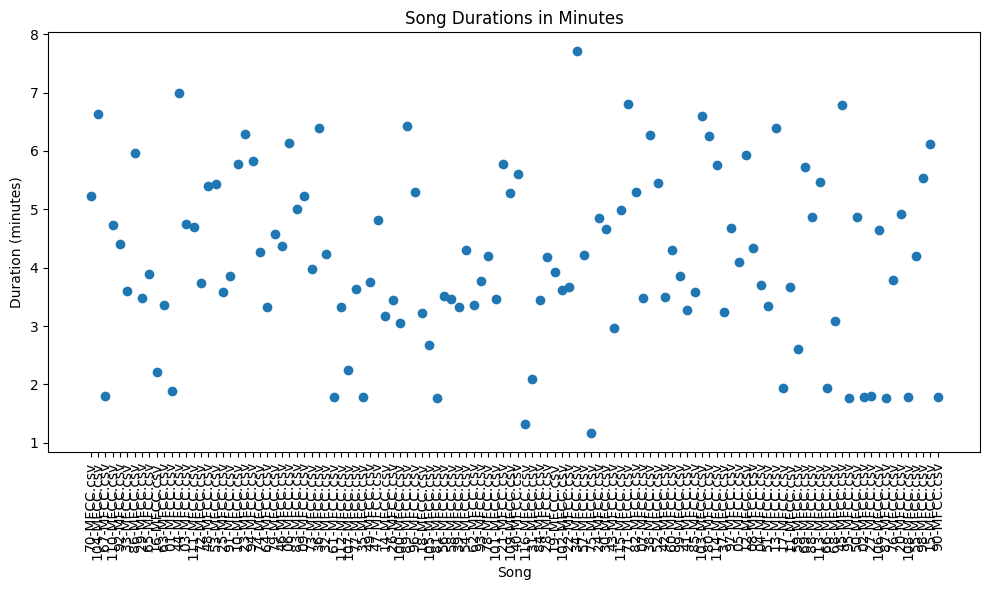

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder path containing the MFCC CSV files
folder_path = '/kaggle/input/real-dataset/MFCC-files-v2-20241024'

# Prepare a list to store results
results = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the CSV file
        df = pd.read_csv(file_path, header=None)
        
        # Calculate the duration of the song in seconds
        time_frames = df.shape[1]
        total_seconds = time_frames / 86  # 86 frames per second
        
        # Convert to minutes and seconds for display
        minutes = int(total_seconds // 60)
        seconds = int(total_seconds % 60)
        duration_formatted = f"{minutes}:{seconds:02}"  # Format as MM:SS
        
        # Append to the results list
        results.append({'Song': filename, 'Duration (minutes:seconds)': duration_formatted, 'Duration (minutes)': total_seconds / 60})

# Create a DataFrame to display or save as CSV
results_df = pd.DataFrame(results)
results_df.to_csv('song_durations_minutes_seconds.csv', index=False)
print(results_df)

# Scatter plot of song durations
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Song'], results_df['Duration (minutes)'])
plt.title('Song Durations in Minutes')
plt.xlabel('Song')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
